<a href="https://colab.research.google.com/github/CoreTheGreat/HBPU-Machine-Learning-Course/blob/main/ML_Chapter2_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 第二章：回归
湖北理工学院《机器学习》课程Notebook

作者：吴兴平

笔记内容概述:
* 2.1 绕不开的房价预测：准备房价预测数据
* 2.2 用线性回归预测房价
* 2.3 梯度下降 Gradient Descend
* 2.4 模型泛化 Generalization


## 2.1 绕不开的房价预测

步骤1：从 http://lib.stat.cmu.edu/datasets/boston 导入房价预测数据

原始数据是一个列数为11的矩阵。每两行内容为一条记录，包含描述房屋的13种特征以及房屋价格。

In [50]:
import pandas as pd # To load house price data
import numpy as np # To manipulate data

# Load from URL
# data_url = 'http://lib.stat.cmu.edu/datasets/boston' # Set url of the dataset
# raw_df = pd.read_csv(data_url, sep='\s+', skiprows=22, header=None) # Load data

# Load from local file
data_url = './Data/houseprice.csv' # Set url of the dataset
raw_df = pd.read_csv(data_url, sep=',', skiprows=1, header=None) # Load data

raw_df.head(10) # Display the raw data

,0,1,2,3,4,5,6,7,8,9,10
0,0.00632,18.00,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3
1,396.90000,4.98,24.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.02731,0.00,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8
3,396.90000,9.14,21.60,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.02729,0.00,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8
5,392.83000,4.03,34.70,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,0.03237,0.00,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7
7,394.63000,2.94,33.40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,0.06905,0.00,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7
9,396.90000,5.33,36.20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


步骤2：重构数据，将原始数据分为一个特征矩阵 (data) 和房价向量 (target)。

注意：特征矩阵的记录数量应与房价数量相同。

特征描述：

* [0] - 按城镇划分的犯罪率
* [1] - 面积超过25,000平方英尺（2322.58平方米）的住宅用地占比
* [2] - 非零售商业用地占比
* [3] - 是否位于查尔斯河畔 ( 1为是，0为否 )
* [4] - 氮氧化物浓度（空气质量） (单位：ppm)
* [5] - 每个住宅的平均房间数
* [6] - 1940年以前建造的自住房比例
* [7] - 到波士顿五个就业中心的加权距离
* [8] - 辐射路可达性指数
* [9] - 每10,000美元的房产税率
* [10] - 学生-教师比率
* [11] - （忽略） 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
* [12] - 低层次人口占比

房价描述:
* 自住房房价中位数（单位：千美元）

In [46]:
import pandas as pd

data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, 1:2]]) # Select features
target = raw_df.values[1::2, 2] # Select target

fts_names = [
    '犯罪率（%）',
    '大住宅用地占比（%）',
    '非零售商业用地占比（%）',
    '景观房',
    '氮氧化物浓度（ppm）',
    '平均房间数',
    '老旧房屋占比（%）',
    '离就业中心的加权距离',
    '辐射路可达性指标',
    '每万元房产税',
    '学生-教师比',
    '低层次人口占比（%）'] # Feature names

print(f'Data shape: {data.shape}, Target shape: {target.shape}') # Display the shape of data and target

Data shape: (506, 12), Target shape: (506,)


步骤3：用散点图（Scatter）展现各个特征与房价之间的关系。

注意：需要安装字体才能在figure中显式中文。[Colab环境中需要]

In [47]:
import matplotlib
from matplotlib import font_manager

font_manager.fontManager.addfont('./Data/simhei.ttf') # Add the font
matplotlib.rc('font', family='SimHei') # Set the font

逐一完成各个特征和房价的散点图

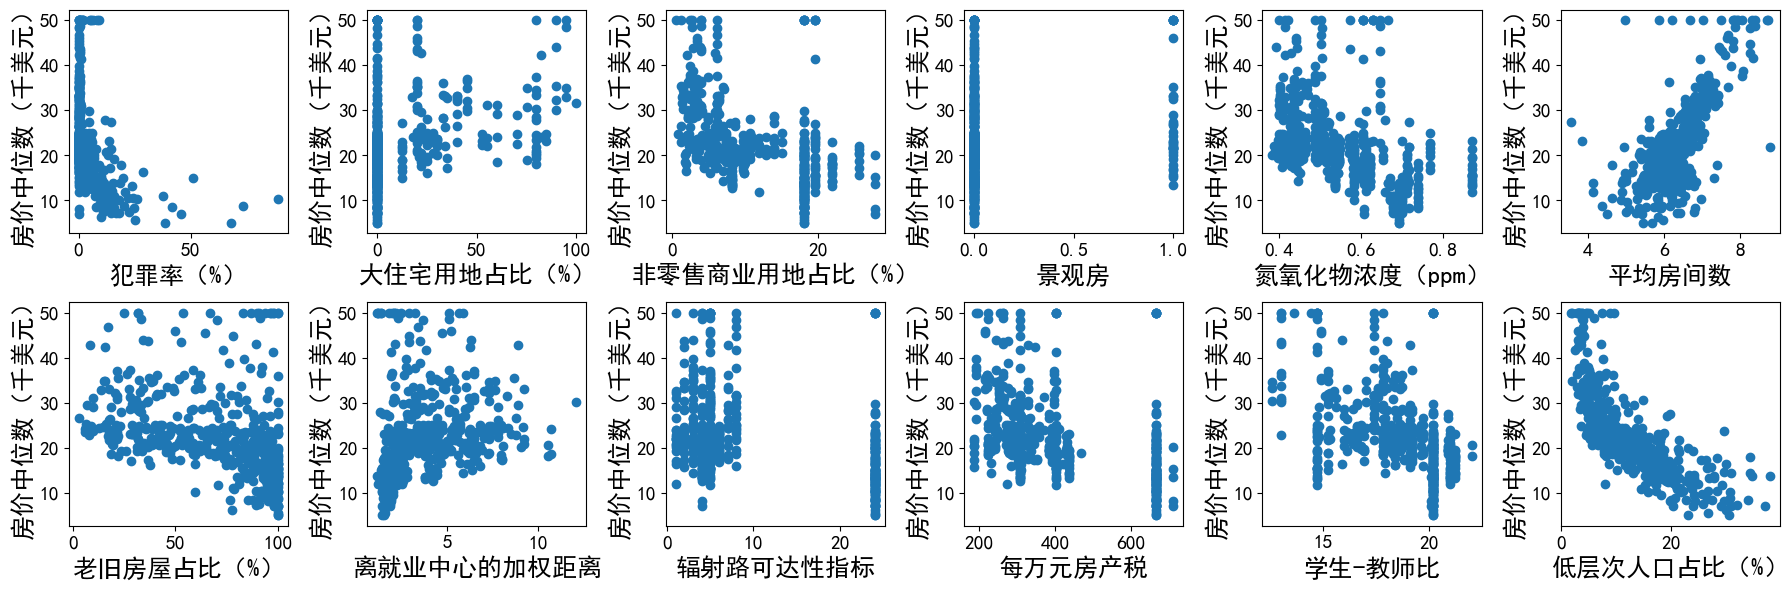

In [48]:
import matplotlib.pyplot as plt # To draw figures

plt.rcParams['font.sans-serif'] = ['SimHei']  # Support Chinese
plt.rcParams['axes.unicode_minus'] = False  # Support negative sign

num_fts = data.shape[1] # Get the number of features
num_col = 6 # Number of columns in the figure
num_row = int(np.ceil(num_fts / num_col)) # Number of rows in the figure

label_size = 18 # Label size
ticklabel_size = 14 # Tick label size

_, axes = plt.subplots(num_row, num_col, figsize=(18, 3*num_row)) # Create a figure

for i in range(num_fts): # Loop through all features
    row = int(i / num_col) # Get the row index
    col = i % num_col # Get the column index

    ax = axes[row, col]
    ax.scatter(data[:, i], target) # Plot scatter fig of i-th feature and target
    ax.tick_params(axis='both', which='major', labelsize=ticklabel_size) # Set tick label size
    ax.set_xlabel(fts_names[i], fontsize=label_size) # Label the x-axis
    ax.set_ylabel('房价中位数（千美元）', fontsize=label_size) # Label the y-axis

plt.tight_layout() # Adjust the layout of the figure
plt.show() # Display the figure

## 2.2 用线性回归预测房价

本节内容包括三个部分：
* 准备一大堆房价数据
* 准备一堆房价预测模型
* 选择最优的房价预测模型

### 2.2.1 准备一大堆房价数据

画出房价与房间数量的散点图，观察房价与房间数量的关系。

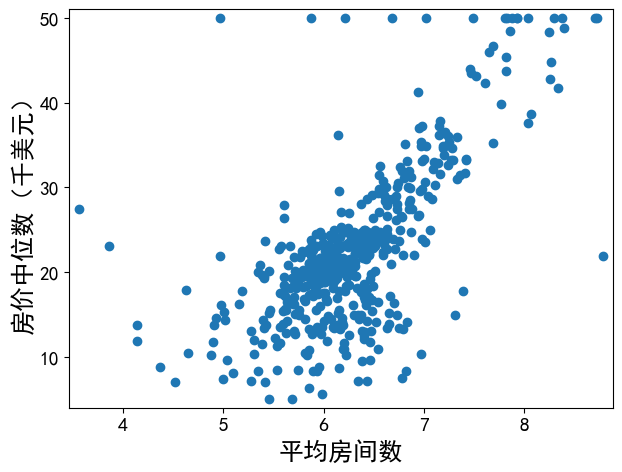

In [9]:
x = data[:, 5] # Get the number of rooms
y = target # Get the target

def draw_scatter(x, y):
    '''
    This a specific function to draw a scatter figure of room number and house price.
    x: room number
    y: house price
    '''
    global label_size, ticklabel_size # Set global variables of font size

    fig, ax = plt.subplots() # Create a figure and a set of subplots.
    ax.scatter(x, y) # Plot the data
    ax.tick_params(axis='both', which='major', labelsize=ticklabel_size) # Set tick label size
    ax.set_xlabel('平均房间数', fontsize=label_size) # Label the x-axis
    ax.set_ylabel('房价中位数（千美元）', fontsize=label_size) # Label the y-axis

    x_min = np.min(x)-0.1 # Get the minimum value of x
    x_max = np.max(x)+0.1 # Get the maximum value of x
    ax.set_xlim(x_min, x_max) # Set the x-axis limits
    ax.set_ylim(np.min(y)-1, np.max(y)+1) # Set the y-axis limits

    ax.set_position([0.12, 0.14, 0.85, 0.83]) # Set the position of the figure

    x_linear = np.linspace(x_min, x_max, 100) # Create a sequence of x to draw prediction function

    return fig, ax, x_linear

fig, ax, _ = draw_scatter(x, y)

# plt.savefig('room_price.png', dpi=300) # Make figure clearer
plt.show()

### 2.2.2 准备一堆房价预测模型

定义预测函数并在图中增加对应的曲线。

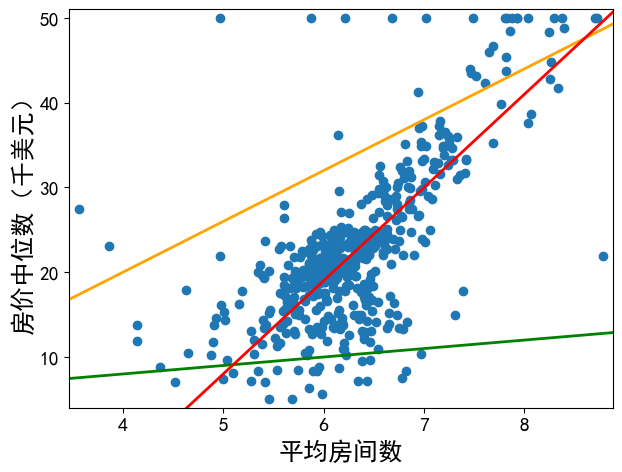

In [10]:
def linear_fun(x, w, b):
    '''
    This a linear prediction function.
    x: feature
    b: bias
    w: weight
    '''

    y = w * x + b

    return y

fig, ax, x_linear = draw_scatter(x, y) # Plot the scatter

ax.plot(x_linear, linear_fun(x_linear, 1, 4), color='green', linewidth=2) # y = x + 4
# plt.savefig('room_price_f1.png', dpi=300) # Make figure clearer

ax.plot(x_linear, linear_fun(x_linear, 6, -4), color='orange', linewidth=2) # y = 6x - 4
# plt.savefig('room_price_f2.png', dpi=300) # Make figure clearer

ax.plot(x_linear, linear_fun(x_linear, 11, -47), color='red', linewidth=2) # y = 11x - 47
# plt.savefig('room_price_f3.png', dpi=300) # Make figure clearer

plt.show()

练习：尝试构建其它的预测模型

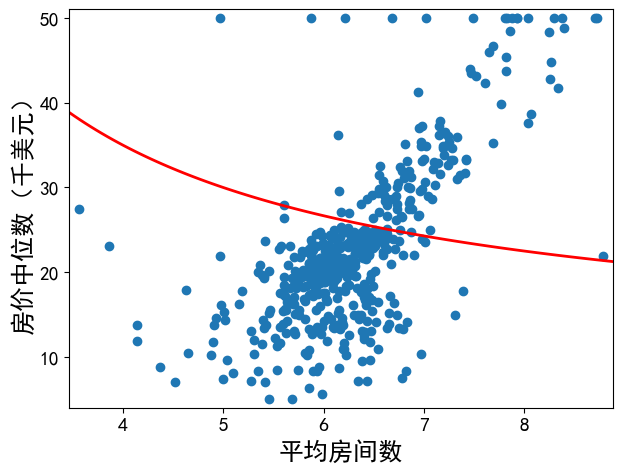

In [11]:
def nonlinear_fun(x, w, b):
    '''
    This an example of non-linear prediction function.
    x: feature
    b: bias
    w: weight

    Return:
    y: prediction
    '''
    return w / x + b


fig, ax, x_linear = draw_scatter(x, y) # Plot the scatter
ax.plot(x_linear, nonlinear_fun(x_linear, 100, 10), color='red', linewidth=2) # 100 / x + 10
plt.show()

### 2.2.3 选择最优的房价预测模型

计算所有预测函数的损失

In [51]:
w_min, w_max = -200, 200 # Weight range
b_min, b_max = -200, 200 # Bias range
param_num = 800 # Number of per parameter

w_list = np.linspace(w_min, w_max, param_num) # Create a sequence of w
b_list = np.linspace(b_min, b_max, param_num) # Create a sequence of b

w_grid, b_grid = np.meshgrid(w_list, b_list) # Create a grid of w and b
loss_grid = np.zeros((param_num, param_num)) # Create a grid of loss

for i in range(param_num):
    for j in range(param_num):
        # Compute loss
        y_pred = linear_fun(x, w_grid[i, j], b_grid[i, j])
        loss_temp = np.mean((y_pred - y) ** 2) / 2
        loss_grid[i, j] = loss_temp / 10 ** 5 # Scale loss for display

用热力图展示loss、w、b之间的关系，并找出最优解

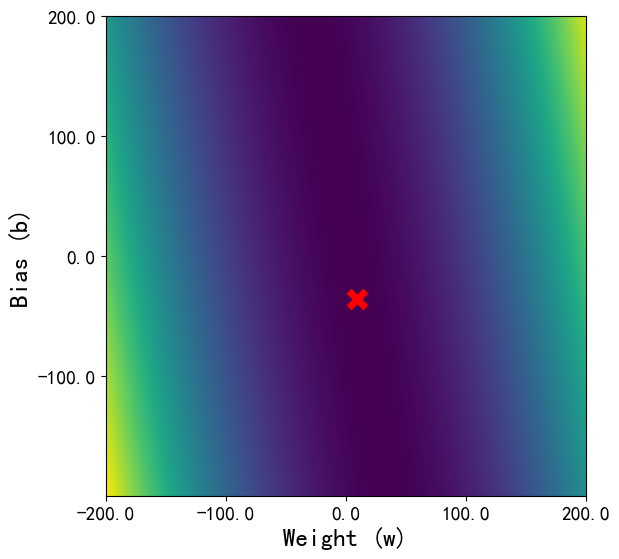

In [52]:
# Draw heatmap first
def draw_heatmap(w_grid, b_grid, loss_grid):
    '''
    Display training process of w and b
    '''
    global label_size, ticklabel_size # Set global variables of font size

    w_min, w_max = -200, 200
    b_min, b_max = -200, 200

    # Set figure
    fig, ax = plt.subplots(figsize=(10,6))

    # Plot the loss
    im = ax.imshow(loss_grid, extent=[w_min, w_max, b_min, b_max], origin='lower', cmap='viridis', zorder=0)

    # Set x-axis and y-axis
    ax.set_xticks(np.linspace(w_min, w_max, 5))
    ax.set_xticklabels(np.linspace(w_min, w_max, 5))
    ax.set_yticks(np.linspace(b_min, b_max, 5)[1:])
    ax.set_yticklabels(np.linspace(b_min, b_max, 5)[1:])
    ax.set_xlabel('Weight (w)', fontsize=label_size)
    ax.set_ylabel('Bias (b)', fontsize=label_size)

    ax.set_xlim(w_min, w_max)
    ax.set_ylim(b_min, b_max)

    ax.set_position([0.15, 0.13, 0.60, 0.8]) # Set the position of the figure

    # Set tick label size
    ax.tick_params(axis='both', which='major', labelsize=ticklabel_size)

    # Mark the point of lowest loss
    min_loss_idx = np.unravel_index(np.argmin(loss_grid), loss_grid.shape)
    min_w = w_grid[min_loss_idx]
    min_b = b_grid[min_loss_idx]
    ax.scatter(min_w, min_b, color='red', marker='x', linewidth=5, s=12**2)

    return fig, ax

fig, ax = draw_heatmap(w_grid, b_grid, loss_grid)

# plt.savefig('loss_with_mark.png', dpi=300) # Make figure clearer
plt.show()

展示最优的房价预测函数

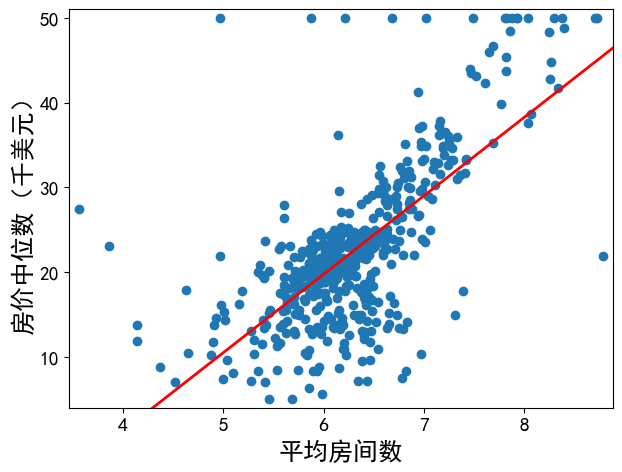

In [53]:
'''
Drawing a figure of the best estimation function
'''

fig, ax, x_linear = draw_scatter(x, y) # Plot the scatter
ax.plot(x_linear, linear_fun(x_linear, 9.26, -35.79), color='red', linewidth=2)
# plt.savefig('room_price_best.png', dpi=300) # Make figure clearer
plt.show()

## 2.3 梯度下降 Gradient Descend

本节包括两个内容：
* 梯度下降的基本逻辑
* 学习率的影响 - 练习：观察不同学习率、迭代次数条件下的训练效果
* 自适应梯度 Adaptive Gradient

### 2.3.1 梯度下降的基本逻辑

仅讨论w的变化（b=-34.67）

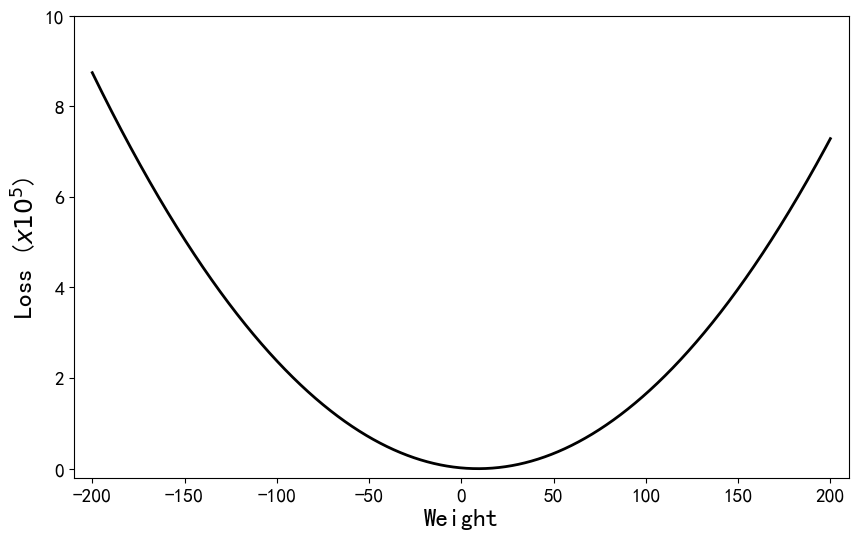

In [20]:
def loss_w_base():
    '''
    Draw the baseline of loss function when b is -34.67
    '''
    global label_size, ticklabel_size # Set global variables of font size

    b = -34.67

    w_min, w_max = -200, 200 # Weight range
    param_num = 10000 # Number of per parameter

    w_base = np.linspace(w_min, w_max, param_num) # Create a sequence of w

    loss_base = np.zeros(param_num) # Create a grid of loss

    for i in range(param_num):
        # Compute loss
        y_pred = linear_fun(x, w_base[i], b)
        loss_base[i] = np.mean((y_pred - y) ** 2) / 2

    fig, ax = plt.subplots(figsize=(10,6))
    ax.plot(w_base, loss_base / 10 ** 5, color='black', linewidth=2, zorder=0) # Scale loss for display
    ax.set_xlim(-210, 210)
    ax.set_ylim(-0.2, 10)
    ax.set_xlabel('Weight', fontsize=label_size)
    ax.set_ylabel('Loss ($x10^5$)', fontsize=label_size)
    ax.tick_params(axis='both', which='major', labelsize=ticklabel_size)

    return fig, ax

fig, ax = loss_w_base()
# plt.savefig('learning_rate_base.png', dpi=300) # Make figure clearer
plt.show()

训练模型: learning rate = 0.00001

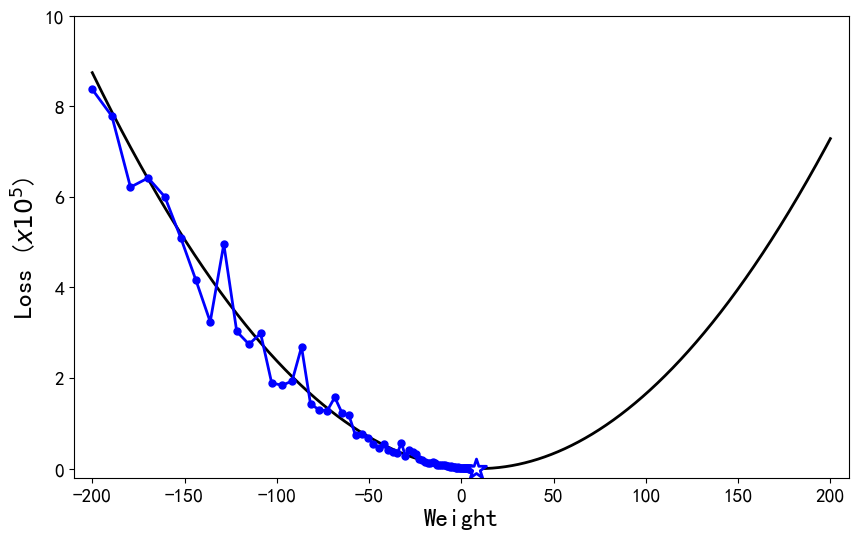

In [21]:
def learn_w(x, y, lr=0.00001, max_epoch=100, batch_size=4, adagrad=None):
    '''
    Learning weight w with fixed bias b
    w starts with -200

    Return:
    w_list: array of w
    loss_list: array of loss
    '''
    w = -200 # Set initial value of w
    b = -34.67 # Fixed bias

    w_list = [w] # Create a list to store w
    loss_list = [] # Create a list to store loss

    # Training
    for ie in range(max_epoch):
        # Shuffle x
        idx = np.random.permutation(x.shape[0])

        # Update learning rate
        if adagrad == 'temporal':
            lr = lr / np.sqrt(ie+1) # Update learning rate

        # Split indices into batches
        dw = 0
        for ib in range(0, x.shape[0], batch_size):
            batch_idx = idx[ib:ib+batch_size]
            x_batch = x[batch_idx]
            y_batch = y[batch_idx]

            y_batch_pred = linear_fun(x_batch, w, b)

            dw = dw + np.mean((y_batch_pred - y_batch) * x_batch) # Compute partial derivative of w

        w -= lr * dw # Update w

        loss_list.append(np.mean((y_batch_pred - y_batch) ** 2) / 2) # Compute and record loss
        w_list.append(w)

    # Final loss
    y_pred = linear_fun(x, w, b)
    loss_list.append(np.mean((y - y_pred) ** 2) / 2) # Compute and record loss

    w_list = np.array(w_list)
    loss_list = np.array(loss_list) / 10 ** 5

    return w_list, loss_list

def add_loss_w(fig, ax, w_list, loss_list):
    global label_size, ticklabel_size # Set global variables of font size

    # Plot training losses
    ax.plot(w_list, loss_list / 10 ** 5, color='blue', linewidth=2, zorder=1)
    ax.legend(ncol=2, fontsize=label_size)

    # Mark final place
    ax.scatter(w_list[-1], loss_list[-1] / 10 ** 5, s=15**2, marker='*', facecolor='white', edgecolor='blue', linewidth=2, zorder=2)

    return fig, ax

# Display training result of lr = 0.001
lr = 0.00001 # Set learning rate

w_list, loss_list = learn_w(x, y, lr) # Training model
fig, ax = loss_w_base() # Draw base losses

ax.plot(w_list, loss_list, color='blue', marker='.', markersize=10, linewidth=2, zorder=1) # Plot training losses
ax.scatter(w_list[-1], loss_list[-1], s=15**2, marker='*', facecolor='white', edgecolor='blue', linewidth=2, zorder=2)

# plt.savefig('learning_rate_D00001.png', dpi=300) # Make figure clearer
plt.show()

以较小的学习率训练模型

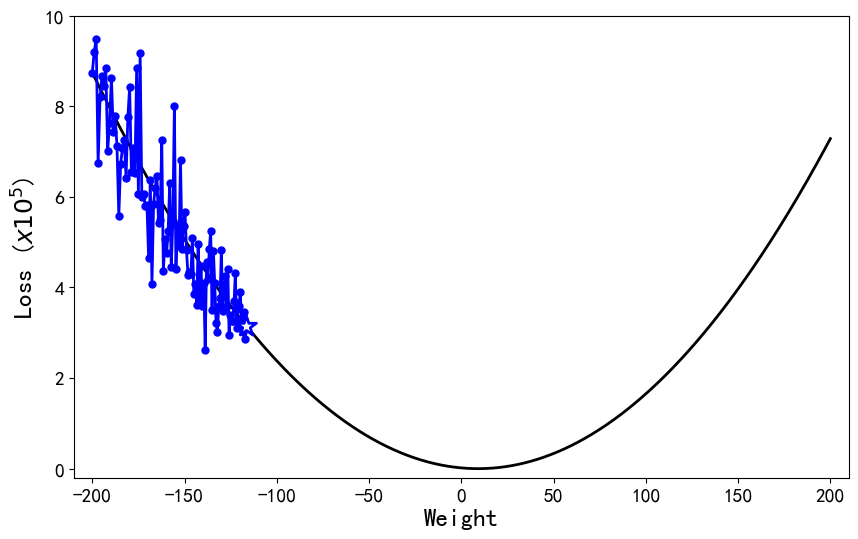

In [22]:
lr = 0.000001 # Set learning rate

w_list, loss_list = learn_w(x, y, lr) # Training model
fig, ax = loss_w_base() # Draw base losses
ax.plot(w_list, loss_list, color='blue', marker='.', markersize=10, linewidth=2, zorder=1) # Plot training losses
ax.scatter(w_list[-1], loss_list[-1], s=15**2, marker='*', facecolor='white', edgecolor='blue', linewidth=2, zorder=2)

# plt.savefig('learning_rate_D000001.png', dpi=300) # Make figure clearer
plt.show()

以更小的学习率训练模型

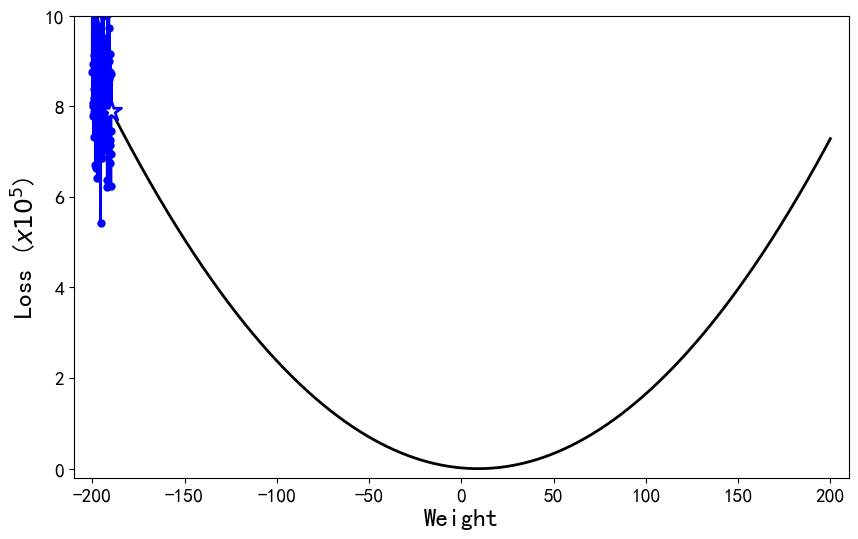

In [23]:
lr = 0.0000001 # Set learning rate

w_list, loss_list = learn_w(x, y, lr) # Training model
fig, ax = loss_w_base() # Draw base losses
ax.plot(w_list, loss_list, color='blue', marker='.', markersize=10, linewidth=2, zorder=1) # Plot training losses
ax.scatter(w_list[-1], loss_list[-1], s=15**2, marker='*', facecolor='white', edgecolor='blue', linewidth=2, zorder=2)

# plt.savefig('learning_rate_D0000001.png', dpi=300) # Make figure clearer
plt.show()

以较大的学习率训练模型

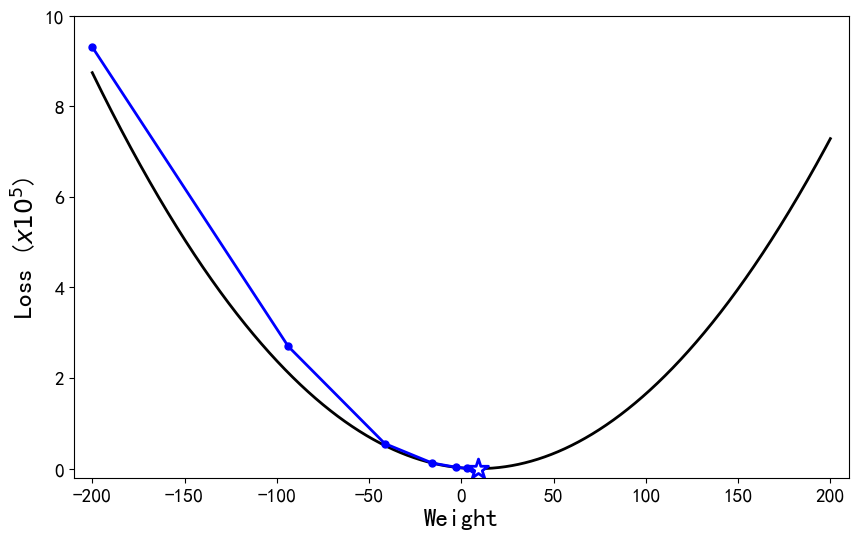

In [24]:
lr = 0.0001 # Set learning rate

w_list, loss_list = learn_w(x, y, lr) # Training model
fig, ax = loss_w_base() # Draw base losses
ax.plot(w_list, loss_list, color='blue', marker='.', markersize=10, linewidth=2, zorder=1) # Plot training losses
ax.scatter(w_list[-1], loss_list[-1], s=15**2, marker='*', facecolor='white', edgecolor='blue', linewidth=2, zorder=2)

# plt.savefig('learning_rate_D0001.png', dpi=300) # Make figure clearer
plt.show()

以更大的学习率训练模型

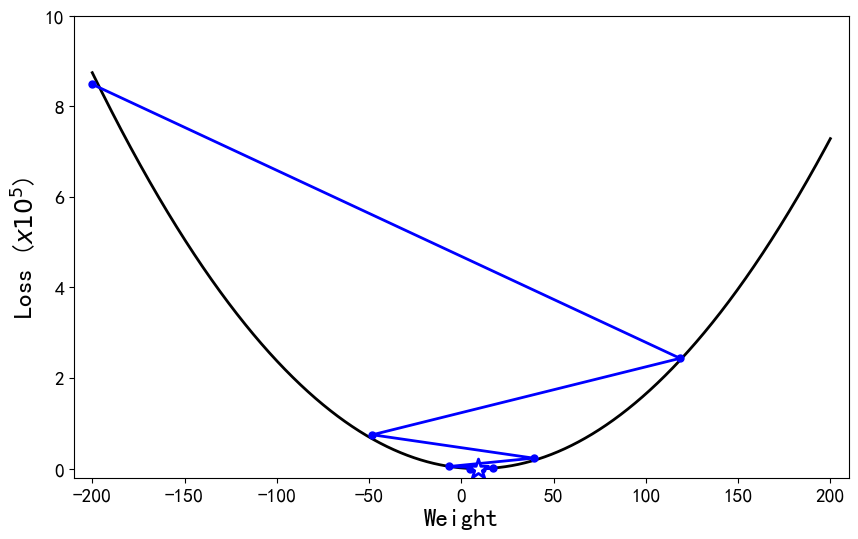

In [25]:
lr = 0.0003 # Set learning rate

w_list, loss_list = learn_w(x, y, lr) # Training model
fig, ax = loss_w_base() # Draw base losses
ax.plot(w_list, loss_list, color='blue', marker='.', markersize=10, linewidth=2, zorder=1) # Plot training losses
ax.scatter(w_list[-1], loss_list[-1], s=15**2, marker='*', facecolor='white', edgecolor='blue', linewidth=2, zorder=2)

# plt.savefig('learning_rate_D0003.png', dpi=300) # Make figure clearer
plt.show()

以更更大的学习率训练模型

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


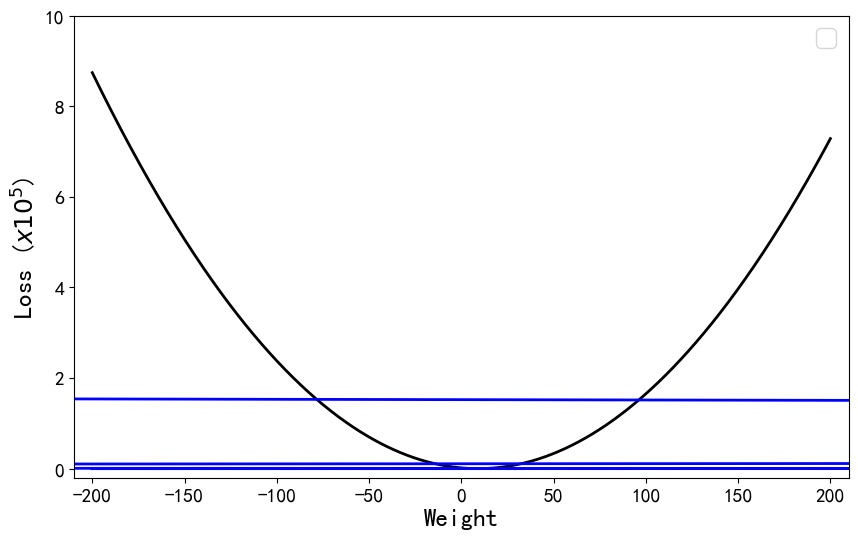

In [26]:
lr = 0.001 # Set learning rate

w_list, loss_list = learn_w(x, y, lr) # Training model
fig, ax = loss_w_base() # Draw base losses
fig, ax = add_loss_w(fig, ax, w_list, loss_list) # Add training losses

# plt.savefig('learning_rate_D001.png', dpi=300) # Make figure clearer
plt.show()

### 2.3.2 练习：观察不同学习率和迭代次数条件下的结果

In [57]:
def compute_loss_and_derivative(x, y, w, b):
    '''
    This a linear prediction function.

    Return loss, dw, db:
    loss: loss of the prediction
    dw: partial derivative of w
    db: partial derivative of b
    '''
    pass

def init_param():
    '''
    This a linear prediction function.

    Return w, b:
    w: weight
    b: bias
    '''
    pass

def train_linear_fun(x, y, lr, num_iter):
    '''
    This a linear prediction function.

    Return training log including losses and parameters:
    loss_list: list of losses
    param_list: list of parameters
    '''
    pass

# Training models in different conditions

### 2.3.4 自适应梯度


同时对w和b进行更新

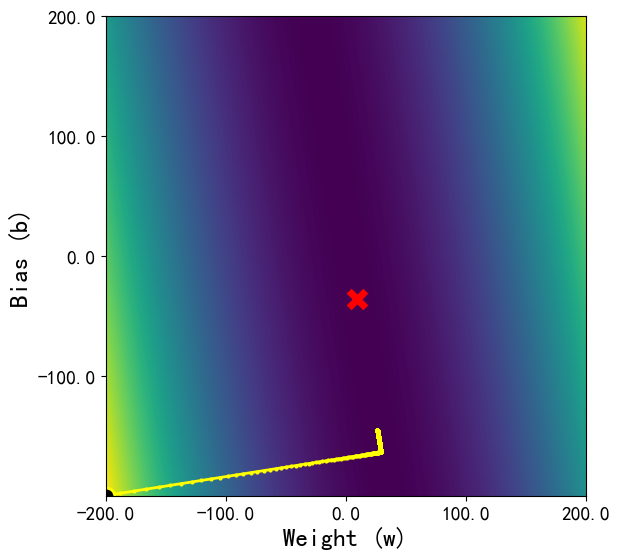

In [28]:
def learn_w_b(x, y, lr=0.0001, max_epoch=100000, batch_size=4, adagrad=False):
    '''
    Learning weight w and bias b
    (w, b) starts with (-200, -200)

    Return:
    w_list: array of w
    b_list: array of b
    loss_final: final loss
    '''
    # Initialize parameters
    w, b = -200, -200

    if adagrad == True:
        lr_w = 0.0
        lr_b = 0.0

    # Model training process
    w_list = [w] # Create a list to store w
    b_list = [b] # Create a list to store b
    for ie in range(max_epoch):
        # Shuffle x
        idx = np.random.permutation(x.shape[0])

        # Split indices into batches
        dw, db = 0, 0
        for ib in range(0, x.shape[0], batch_size):
            batch_idx = idx[ib:ib+batch_size]
            x_batch = x[batch_idx]
            y_batch = y[batch_idx]

            y_batch_pred = linear_fun(x_batch, w, b)

            dw = dw + np.mean((y_batch_pred - y_batch) * x_batch) # Compute partial derivative of w
            db = db + np.mean((y_batch_pred - y_batch) * 1.0) # Compute partial derivative of b

        if adagrad == True:
            lr_w = lr_w + dw ** 2
            lr_b = lr_b + db ** 2

            w -= lr / np.sqrt(lr_w) * dw # Update w
            b -= lr / np.sqrt(lr_b) * db # Update d

        else:
            w -= lr * dw # Update w
            b -= lr * db # Update d

        w_list.append(w)
        b_list.append(b)

    # Change list into array for plotting
    w_list = np.array(w_list)
    b_list = np.array(b_list)

    # Final loss
    y_pred = linear_fun(x, w, b)
    loss_final = np.mean((y - y_pred) ** 2) / 2 # Compute and record loss

    return w_list, b_list, loss_final

w_list, b_list, loss_final = learn_w_b(x, y, lr=0.00001, max_epoch=10000)

fig, ax = draw_heatmap(w_grid, b_grid, loss_grid) # Draw base image
ax.plot(w_list, b_list, color='yellow', marker='.', linewidth=2, markersize=4, zorder=1) # Plot training losses
ax.scatter(w_list[0], b_list[0], color='yellow', facecolor='black', marker='o', linewidth=2, s=12**2, zorder=2) # Add start place

# plt.savefig('f2_learning_rate_D00001.png', dpi=300) # Make figure clearer
plt.show()

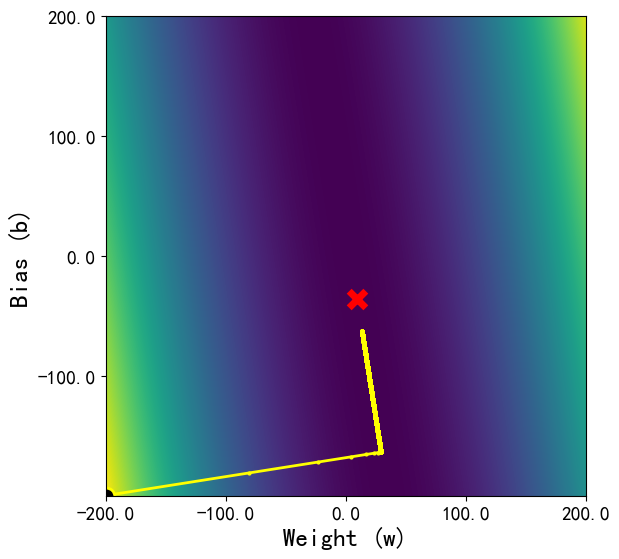

In [29]:
w_list, b_list, loss_final = learn_w_b(x, y, lr=0.0001, max_epoch=10000)

fig, ax = draw_heatmap(w_grid, b_grid, loss_grid) # Draw base image
ax.plot(w_list, b_list, color='yellow', marker='.', linewidth=2, markersize=4, zorder=1) # Plot training losses
ax.scatter(w_list[0], b_list[0], color='yellow', facecolor='black', marker='o', linewidth=2, s=12**2, zorder=2) # Add start place

# plt.savefig('f2_learning_rate_D0001.png', dpi=300) # Make figure clearer
plt.show()

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_39228\2819138729.py:34: RuntimeWarning: overflow encountered in scalar add
  dw = dw + np.mean((y_batch_pred - y_batch) * x_batch) # Compute partial derivative of w
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_39228\2819138729.py:45: RuntimeWarning: invalid value encountered in scalar subtract
  w -= lr * dw # Update w


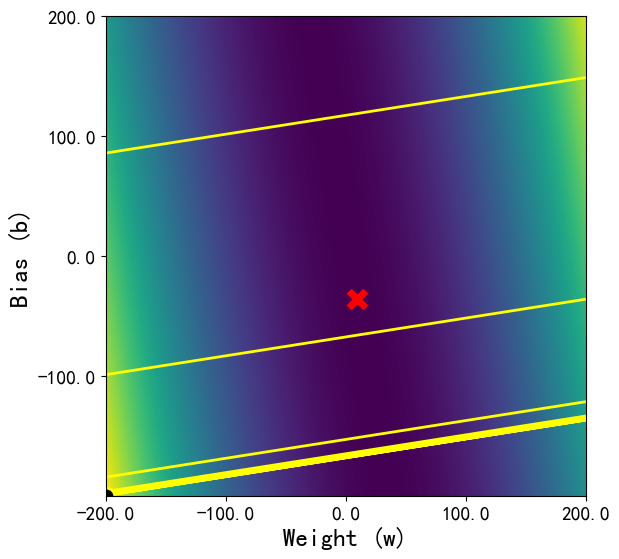

In [55]:
w_list, b_list, loss_final = learn_w_b(x, y, lr=0.001, max_epoch=10000)

fig, ax = draw_heatmap(w_grid, b_grid, loss_grid) # Draw base image
ax.plot(w_list, b_list, color='yellow', marker='.', linewidth=2, markersize=4, zorder=1) # Plot training losses
ax.scatter(w_list[0], b_list[0], color='yellow', facecolor='black', marker='o', linewidth=2, s=12**2, zorder=2) # Add start place

# plt.savefig('f2_learning_rate_D001.png', dpi=300) # Make figure clearer
plt.show()

让学习率随时间减小

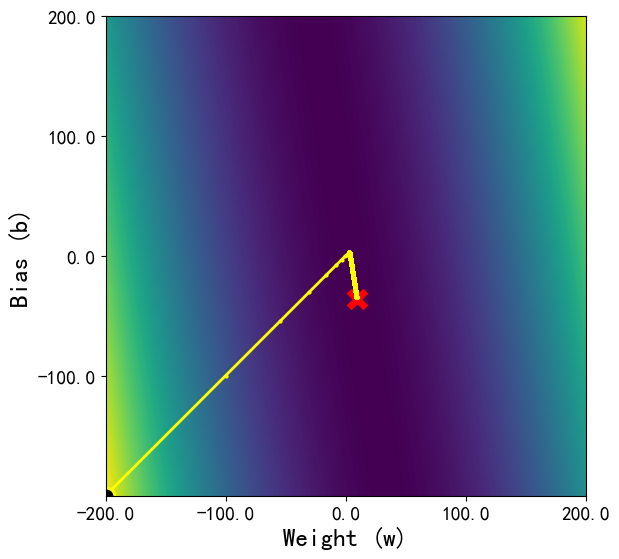

In [31]:
w_list, b_list, loss_final = learn_w_b(x, y, lr=100, max_epoch=10000, adagrad=True)

fig, ax = draw_heatmap(w_grid, b_grid, loss_grid) # Draw base image
ax.plot(w_list, b_list, color='yellow', marker='.', linewidth=2, markersize=4, zorder=1) # Plot training losses
ax.scatter(w_list[0], b_list[0], color='yellow', facecolor='black', marker='o', linewidth=2, s=12**2, zorder=2) # Add start place

# plt.savefig('f2_Adagrad_D001.png', dpi=300) # Make figure clearer
plt.show()

## 2.4 模型泛化 Generalization

构建数据集与测试集，观察模型复杂度与预测结果的关系

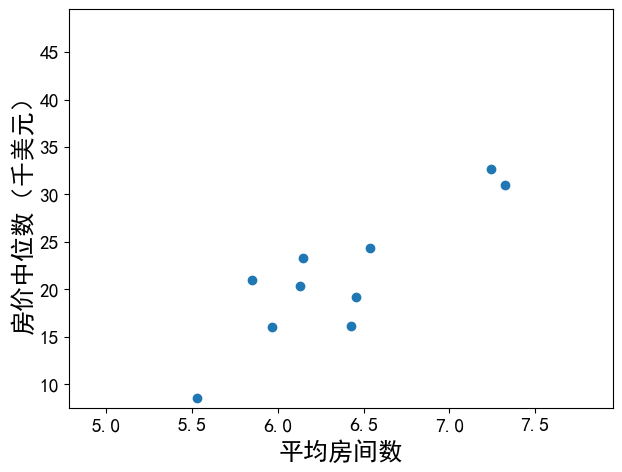

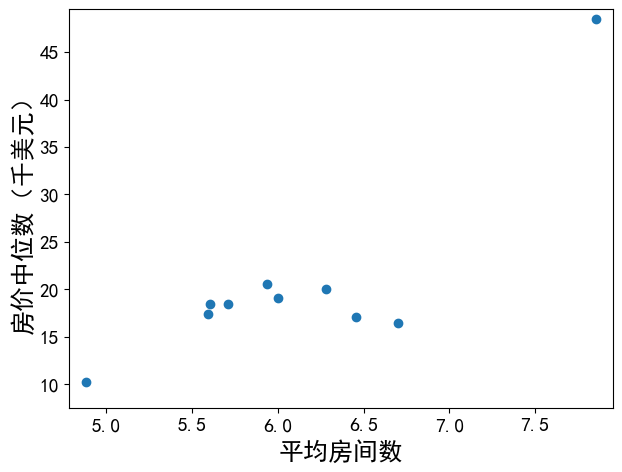

In [32]:
from sklearn.model_selection import train_test_split

def normalization(x, norm_type='none'):
    '''
    Normalization
    '''
    if norm_type == 'min-max':
        a, b = np.min(x), np.max(x)
        x_norm = (x - a) / (b - a)

    elif norm_type == 'z-score':
        a, b = np.mean(x), np.std(x)
        x_norm = (x - a) / b
    
    elif norm_type == 'none':
        a, b = 0, 0
        x_norm = x

    return x_norm, a, b

def norm_recover(x_norm, a, b, norm_type='none'):
    '''
    Normalization
    '''
    if norm_type == 'min-max':
        x = x_norm * (b - a) + a

    elif norm_type == 'z-score':
        x = x_norm * b + a

    elif norm_type == 'none':
        x = x_norm

    return x

def draw_uniform_scatter(x, y, xlim, ylim):
    '''
    This a specific function to draw a scatter figure of room number and house price.
    x: room number
    y: house price
    '''
    global label_size, ticklabel_size # Set global variables of font size

    fig, ax = plt.subplots() # Create a figure and a set of subplots.
    ax.scatter(x, y) # Plot the data
    ax.tick_params(axis='both', which='major', labelsize=ticklabel_size) # Set tick label size
    ax.set_xlabel('平均房间数', fontsize=label_size) # Label the x-axis
    ax.set_ylabel('房价中位数（千美元）', fontsize=label_size) # Label the y-axis

    ax.set_xlim(xlim[0], xlim[1]) # Set the x-axis limits
    ax.set_ylim(ylim[0], ylim[1]) # Set the y-axis limits

    ax.set_position([0.12, 0.14, 0.85, 0.83]) # Set the position of the figure

    x_linear = np.linspace(xlim[0], xlim[1], 100) # Create a sequence of x to draw prediction function

    return fig, ax, x_linear
    
norm_type = 'z-score'

# Normalize x
x_norm, x_a, x_b = normalization(x, norm_type=norm_type)

# Split data into training and testing domains (Not for this section)
X_train, X_test, Y_train, Y_test = train_test_split(x_norm, y, test_size=0.2, random_state=42)

num_samples = 10
np.random.seed(42) # Set the random seed for reproducibility
random_indices = np.random.choice(X_train.shape[0], num_samples, replace=False)
x_train = X_train[random_indices]
y_train = Y_train[random_indices]

random_indices = np.random.choice(X_test.shape[0], num_samples, replace=False)
x_test = X_test[random_indices]
y_test = Y_test[random_indices]

x_test_scatter = norm_recover(x_test, x_a, x_b, norm_type=norm_type)

# Plot the training data
x_lim_offset = 0.1
x_train_scatter = norm_recover(x_train, x_a, x_b, norm_type=norm_type)
x_scatter_min = np.min([np.min(x_train_scatter), np.min(x_test_scatter)]) - x_lim_offset
x_scatter_max = np.max([np.max(x_train_scatter), np.max(x_test_scatter)]) + x_lim_offset
x_lim = [x_scatter_min, x_scatter_max]

y_lim_offset = 1
y_scatter_min = np.min([np.min(y_train), np.min(y_test)]) - y_lim_offset
y_scatter_max = np.max([np.max(y_train), np.max(y_test)]) + y_lim_offset
y_lim = [y_scatter_min, y_scatter_max]

fig, ax, _ = draw_uniform_scatter(x_train_scatter, y_train, x_lim, y_lim)
# plt.savefig(f'scatter_train_data_{num_samples}.png', dpi=300) # Make figure clearer
plt.show()

# Plot the testing data
fig, ax, _ = draw_uniform_scatter(x_test_scatter, y_test, x_lim, y_lim)
# plt.savefig(f'scatter_test_data_{num_samples}.png', dpi=300) # Make figure clearer
plt.show()

In [33]:
def train_poly_mdl(x_tr, y_tr, x_te, y_te, lr=100, max_epoch=1000000, batch_size=1, p=0, regulization_method='none', regulization_lambda=0, disp=False, stop=False):
    '''
    Learning weight w and bias b
    p is the order of polynomial

    Return:
    w_list: array of w
    b_list: array of b
    err_train: prediction accuracy
    '''
    global norm_type

    # Train logs
    logs = {}
    logs['epoch_itr'] = []
    logs['loss_train'] = []
    logs['loss_test'] = []
    logs['loss_batch'] = []
    logs['err_train'] = []
    logs['err_test'] = []

    # Initialize w, b, and exponential x
    b = 0.0
    if p > 0:
        w = np.random.randn(p)
        
        x_tr = [x_tr ** (i+1) for i in range(p)]
        x_tr = np.array(x_tr).T
        
        x_te = [x_te ** (i+1) for i in range(p)]
        x_te = np.array(x_te).T
        
    else:
        w = np.random.randn(x_tr.shape[1])

    # Initialize learning rate
    lr_w = np.zeros(w.size)
    lr_b = 0.0

    # For early stop
    min_err = 100000000
    err_no_improvement = 0
    early_stop = 100

    # Model training process
    itr_num = 0
    for ie in range(max_epoch):

        idx = np.random.permutation(x_tr.shape[0]) # Shuffle x

        dw = np.zeros(w.size)
        db = 0.0

        for ib in range(0, x_tr.shape[0], batch_size):
            batch_idx = idx[ib:ib+batch_size]
            x_batch = x_tr[batch_idx, :]
            y_batch = y_tr[batch_idx]

            y_batch_pred = np.matmul(x_batch, w) + b
            y_batch_diff = y_batch_pred - y_batch
            
            # Regularization in loss and gradient
            if regulization_method == 'L1':
                loss_reg = regulization_lambda * np.sum(np.abs(w))
                grad_reg = regulization_lambda * np.sign(w)
            elif regulization_method == 'L2':
                loss_reg = regulization_lambda * np.sum(w ** 2) / 2
                grad_reg = regulization_lambda * w
            else:
                loss_reg = 0.0
                grad_reg = np.zeros(w.size)

            logs['loss_batch'].append(np.mean(y_batch_diff ** 2) / 2 + loss_reg)

            # Compute partial derivative of w and b
            for i in range(w.size):
                dw[i] = dw[i] + np.mean(y_batch_diff * x_batch[:, i]) + grad_reg[i]
            db = db + np.mean(y_batch_diff * 1.0) # Compute partial derivative of b
            
            itr_num += 1

        # Regularization in loss and gradient
        if regulization_method == 'L1':
            loss_reg = regulization_lambda * np.sum(np.abs(w))
            
        elif regulization_method == 'L2':
            loss_reg = regulization_lambda * np.sum(w ** 2) / 2
            
        else:
            loss_reg = 0
        
        # Compute epoch loss and err
        y_tr_pred = np.matmul(x_tr, w) + b
        y_tr_diff = y_tr_pred - y_tr
        
        loss_train = np.mean(y_tr_diff ** 2) / 2 + loss_reg
        logs['loss_train'].append(loss_train)
        
        err_train = np.mean(np.abs(y_tr_diff))
        logs['err_train'].append(err_train)
                
        y_te_pred = np.matmul(x_te, w) + b
        y_te_diff = y_te_pred - y_te
        
        loss_test = np.mean(y_te_diff ** 2) / 2 + loss_reg
        logs['loss_test'].append(loss_test)
        
        err_test = np.mean(np.abs(y_te_diff))
        logs['err_test'].append(err_test)
        
        # Display training process
        if (ie + 1) % 10000 == 0 and disp == True:
            print(f'Epoch {ie+1}: train loss ({loss_train:.8f}), test loss ({loss_test:.8f}), train error ({err_train:.4f}), test error ({err_test:.4f})')
        
        # Early stop
        if stop == True:
            if err_test < min_err:
                min_err = err_test
                err_no_improvement = 0
            else:
                err_no_improvement += 1

            if err_no_improvement >= early_stop:
                break

        # Adagrad
        lr_w = lr_w + dw ** 2
        lr_b = lr_b + db ** 2

        w -= lr / np.sqrt(lr_w) * dw # Update w
        b -= lr / np.sqrt(lr_b) * db # Update d

    # Regularization in loss and gradient
    if regulization_method == 'L1':
        loss_reg = regulization_lambda * np.sum(np.abs(w))
        
    elif regulization_method == 'L2':
        loss_reg = regulization_lambda * np.sum(w ** 2) / 2
        
    else:
        loss_reg = 0

    # Compute epoch loss and err
    y_tr_pred = np.matmul(x_tr, w) + b
    y_tr_diff = y_tr_pred - y_tr

    loss_train = np.mean(y_tr_diff ** 2) / 2 + loss_reg
    logs['loss_train'].append(loss_train)
    
    err_train = np.mean(np.abs(y_tr_diff))
    logs['err_train'].append(err_train)
            
    y_te_pred = np.matmul(x_te, w) + b
    y_te_diff = y_te_pred - y_te

    loss_test = np.mean(y_te_diff ** 2) / 2 + loss_reg
    logs['loss_test'].append(loss_test)
    
    err_test = np.mean(np.abs(y_te_diff))
    logs['err_test'].append(err_test)
    
    # Change logs to array
    logs['loss_train'] = np.array(logs['loss_train'])
    logs['err_train'] = np.array(logs['err_train'])
    logs['loss_test'] = np.array(logs['loss_test'])
    logs['err_test'] = np.array(logs['err_test'])

    return w, b, logs

In [34]:
p_list = range(1, 11, 1) # Set the order of polynomial
param_list = []
err_list = []

for p in p_list:
    # Train model
    w, b, logs = train_poly_mdl(x_train, y_train, x_test, y_test, p=p, lr=100, max_epoch=10000, batch_size=num_samples)
    param_list.append((w, b))

    err_train = logs['err_train'][-1]
    err_test = logs['err_test'][-1]
    err_list.append((err_train, err_test))

    print(f'p={p}\t Training avg_err: {err_train}\t Testing avg_err: {err_test}')

p=1	 Training avg_err: 2.8898418256399423	 Testing avg_err: 4.9989056220327
p=2	 Training avg_err: 2.86878856935306	 Testing avg_err: 5.1824471458777435
p=3	 Training avg_err: 2.4947969414931563	 Testing avg_err: 9.776274245103085
p=4	 Training avg_err: 1.830002792195467	 Testing avg_err: 27.693371711085614
p=5	 Training avg_err: 1.8543885582291835	 Testing avg_err: 26.20848282537674
p=6	 Training avg_err: 1.865461731254981	 Testing avg_err: 47.84924749227257
p=7	 Training avg_err: 1.8404993838474106	 Testing avg_err: 51.925377284213916
p=8	 Training avg_err: 1.8578458989679905	 Testing avg_err: 110.66481700647628
p=9	 Training avg_err: 1.8502866065808696	 Testing avg_err: 123.11731350698408
p=10	 Training avg_err: 1.9959962486236467	 Testing avg_err: 145.83850373088586


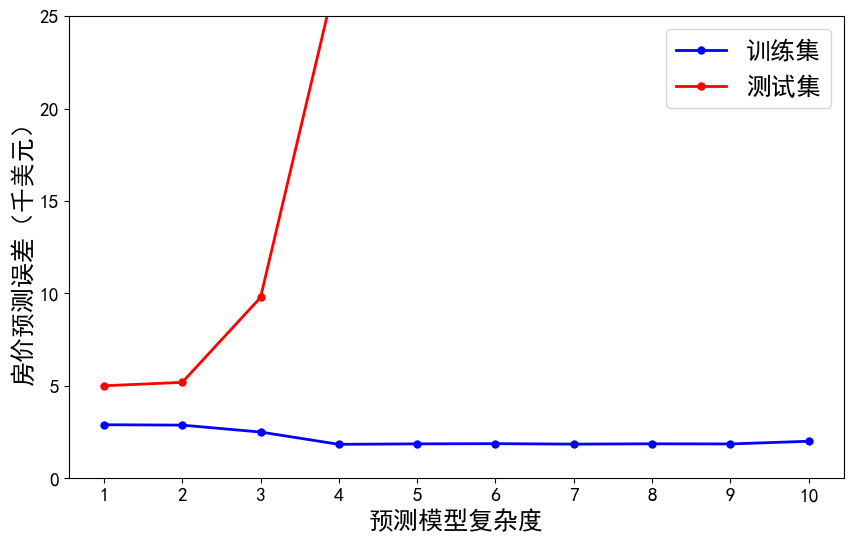

In [35]:
err_list = np.array(err_list)

fig, ax = plt.subplots(figsize=(10,6))
plt.plot(p_list, err_list[:, 0], color='blue', marker='.', markersize=10, linewidth=2, zorder=1, label='训练集') # Plot training losses
plt.plot(p_list, err_list[:, 1], color='red', marker='.', markersize=10, linewidth=2, zorder=1, label='测试集') # Plot training losses
plt.legend(ncol=1, fontsize=label_size)

ax.set_xticks(p_list)
ax.set_ylim(0, 25)

ax.set_xlabel('预测模型复杂度', fontsize=label_size)
ax.set_ylabel('房价预测误差（千美元）', fontsize=label_size)
ax.tick_params(axis='both', which='major', labelsize=ticklabel_size)

# plt.savefig('complexity_vs_error.png', dpi=300) # Make figure clearer
plt.show()

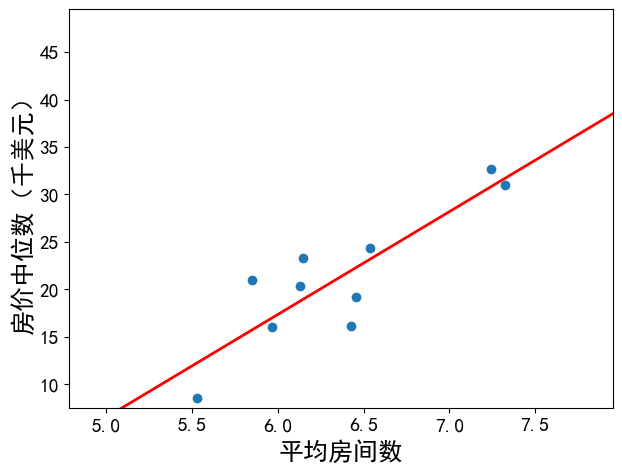

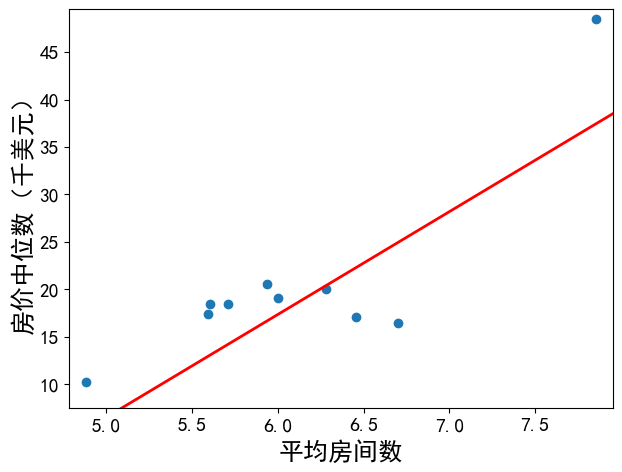

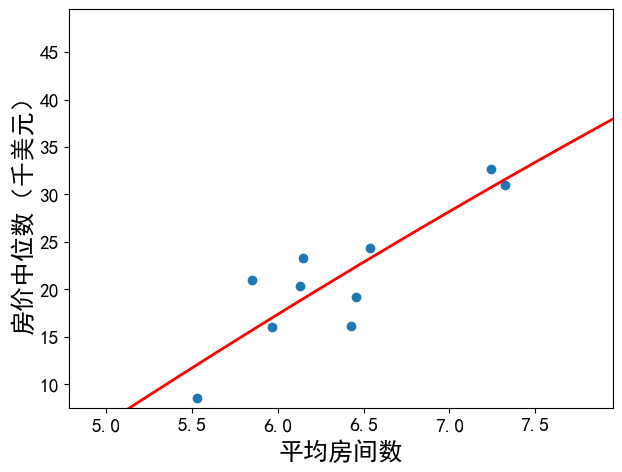

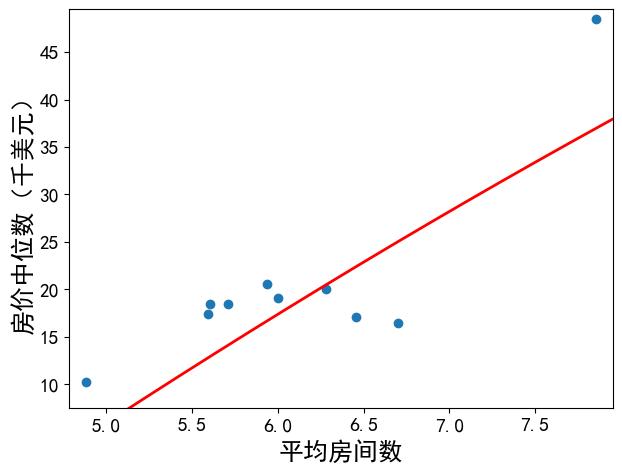

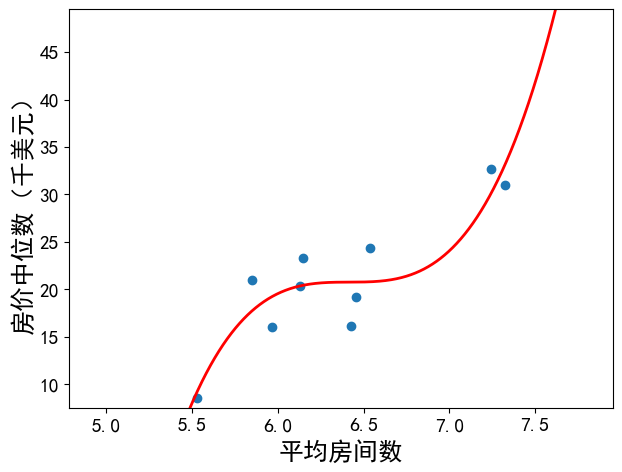

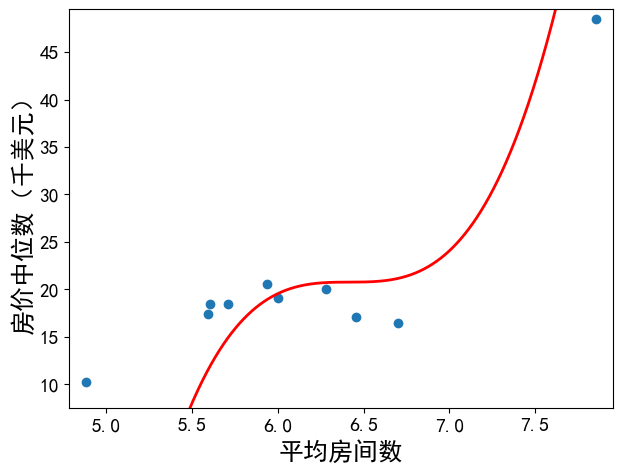

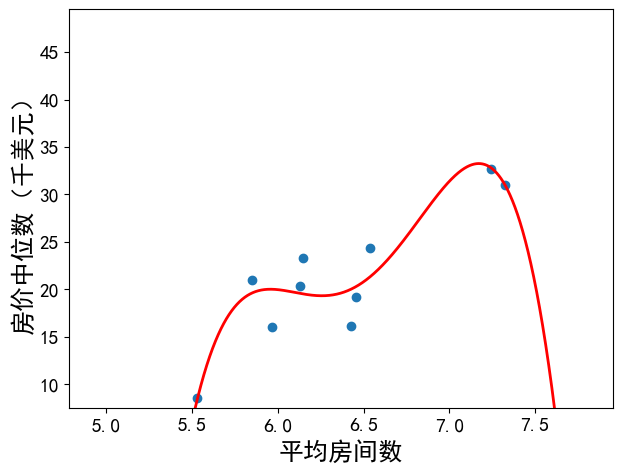

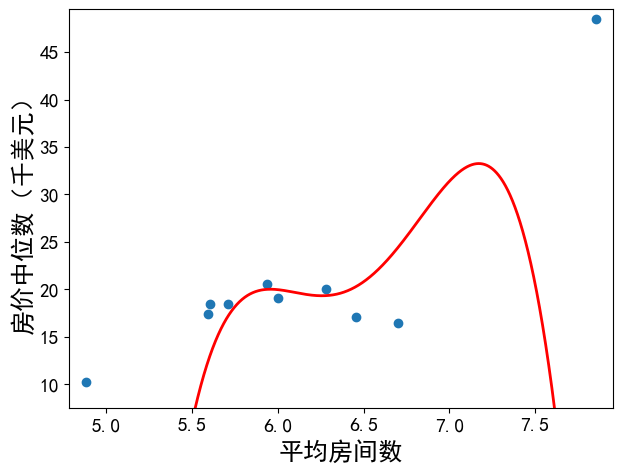

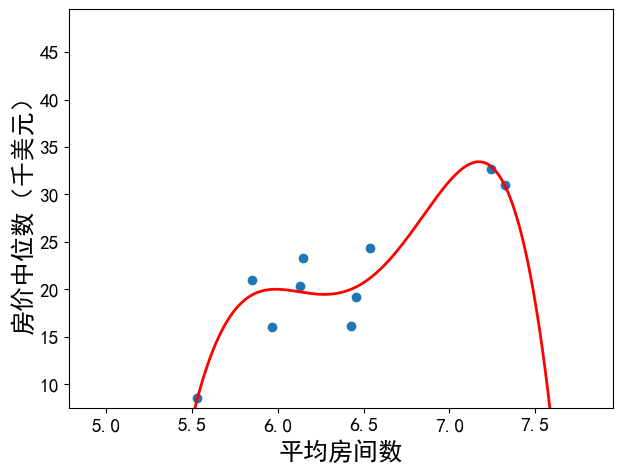

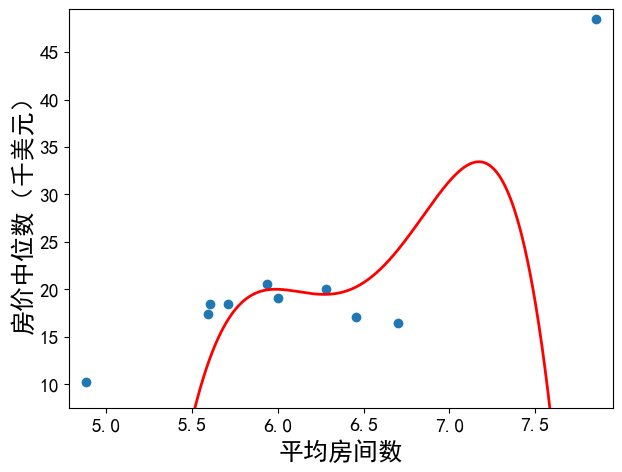

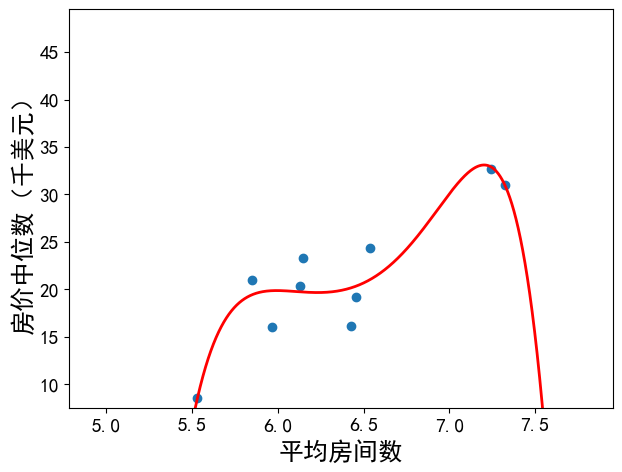

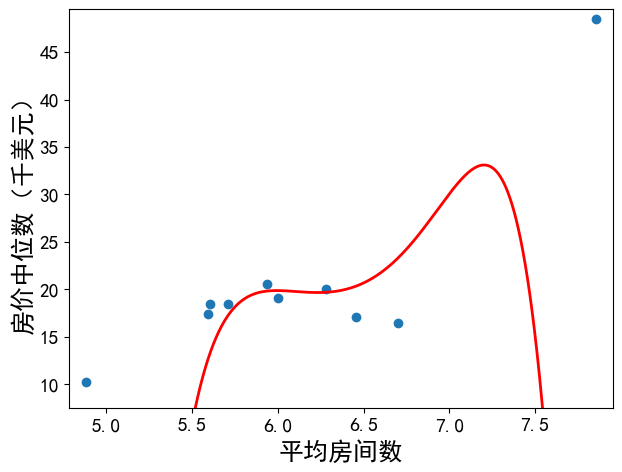

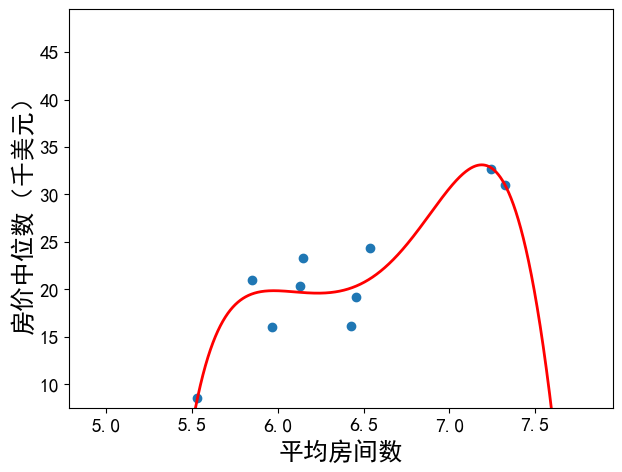

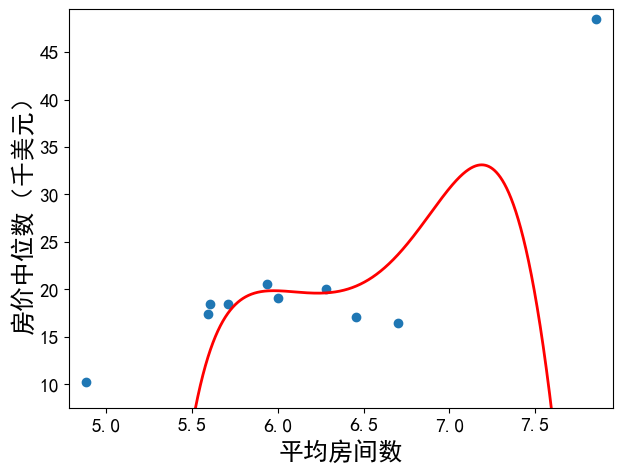

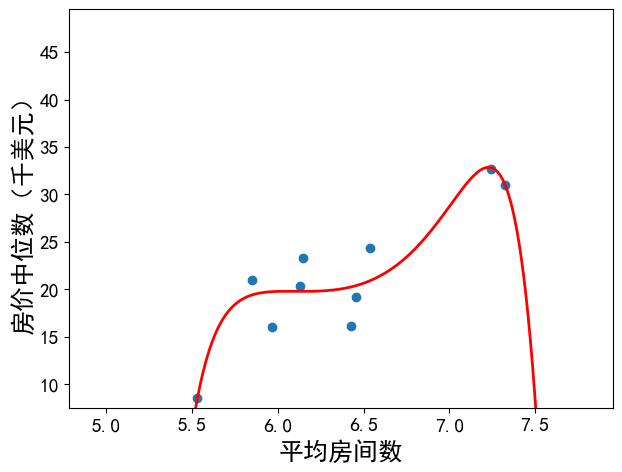

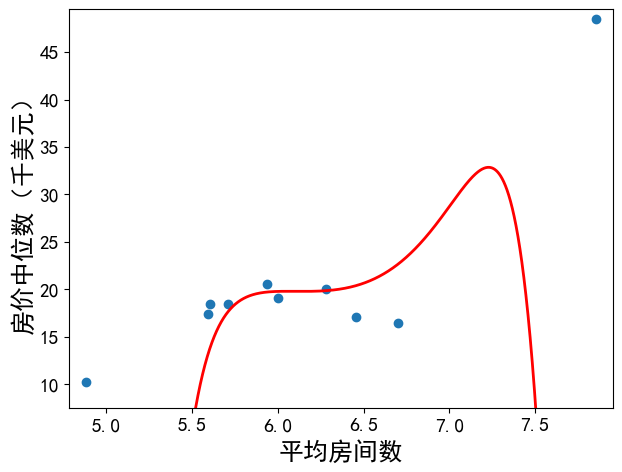

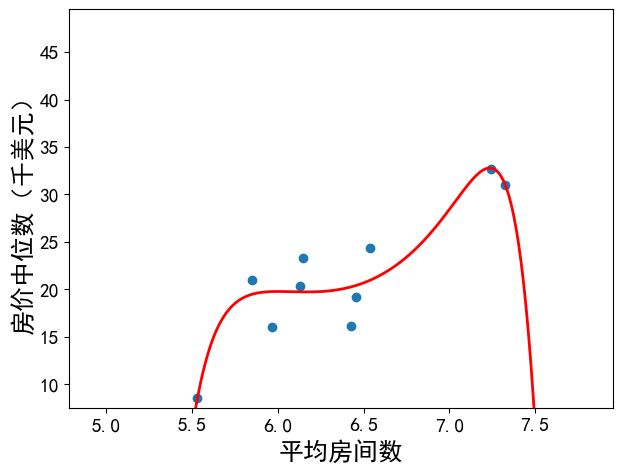

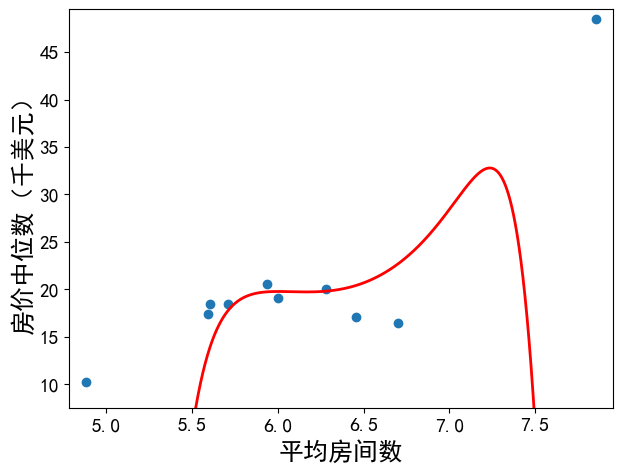

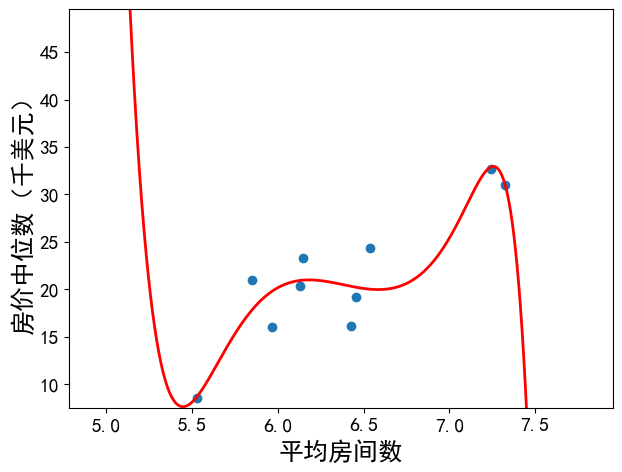

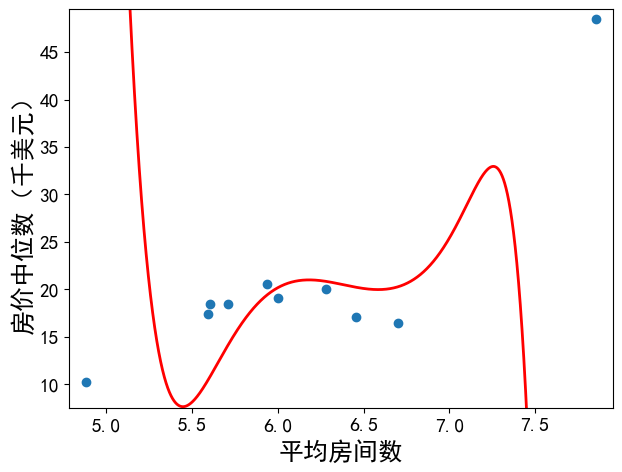

In [36]:
x_min = np.min([np.min(x_train), np.min(x_test)]) - 1
x_max = np.max([np.max(x_train), np.max(x_test)]) + 1

x_linear = np.linspace(x_min, x_max, 10000) # Create a sequence of x to draw prediction function

x_linear_scatter = norm_recover(x_linear, x_a, x_b, norm_type=norm_type)

for i in range(len(p_list)):
    p = p_list[i]
    w, b = param_list[i]

    # Draw prediction function
    fig, ax, _ = draw_uniform_scatter(x_train_scatter, y_train, x_lim, y_lim) # Plot the scatter

    x_linear_exp = [x_linear ** (i+1) for i in range(p)]
    x_linear_exp = np.array(x_linear_exp).T

    y_linear = np.matmul(x_linear_exp, w) + b

    ax.plot(x_linear_scatter, y_linear, color='red', linewidth=2)

    # plt.savefig(f'polylinearfit_p{p}.png', dpi=300) # Make figure clearer
    plt.show()

    # Draw prediction function
    fig, ax, _ = draw_uniform_scatter(x_test_scatter, y_test, x_lim, y_lim) # Plot the scatter

    x_linear_exp = [x_linear ** (i+1) for i in range(p)]
    x_linear_exp = np.array(x_linear_exp).T

    y_linear = np.matmul(x_linear_exp, w) + b

    ax.plot(x_linear_scatter, y_linear, color='red', linewidth=2)

    # plt.savefig(f'polylinearfit_test_p{p}.png', dpi=300) # Make figure clearer
    plt.show()

## 2.5 过拟合的解决办法

2.5.1 数据增强

扩展数据集规模

In [37]:
num_samples = 200 # Expand train sample to 200
np.random.seed(42) # Set the random seed for reproducibility
random_indices = np.random.choice(X_train.shape[0], num_samples, replace=False)
x_train = X_train[random_indices]
y_train = Y_train[random_indices]

# Train model
p = 10
w, b, logs = train_poly_mdl(x_train, y_train, x_test, y_test, p=p, lr=100, max_epoch=100000, batch_size=10)

err_train = logs['err_train'][-1]
err_test = logs['err_test'][-1]

print(f'p={p}\t Training avg_err: {err_train}\t Testing avg_err: {err_test}')

p=10	 Training avg_err: 5.1447588836876	 Testing avg_err: 7.71049353350743


Parameter b: 21.36791285433096
Parameters w: [ 1.02934400e+01  1.19983451e+00  2.54109601e+00 -1.72358216e+00
 -2.76606109e+00  1.29271938e+00  4.68989687e-01 -2.10690010e-01
 -2.17531629e-02  9.61239959e-03]


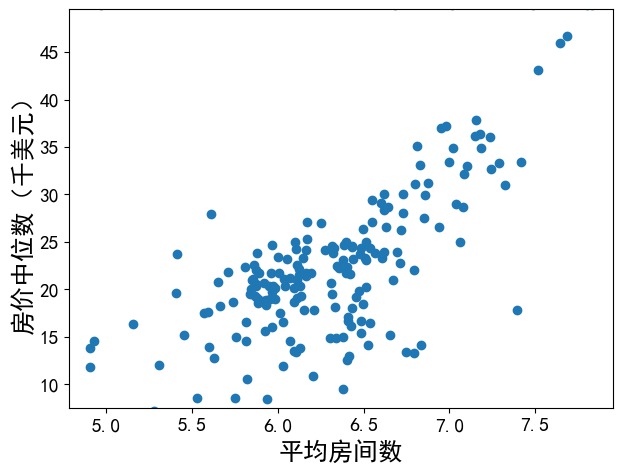

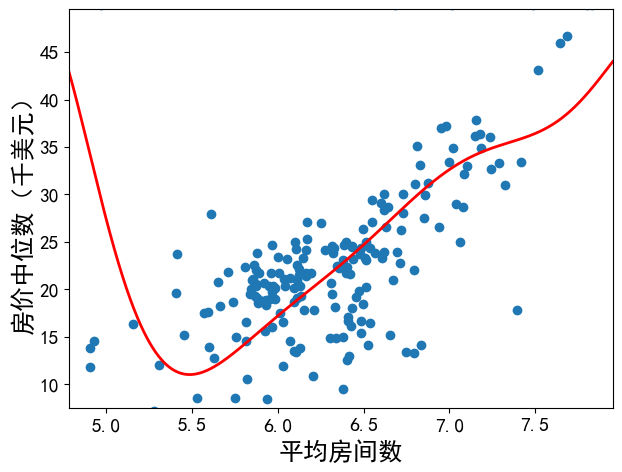

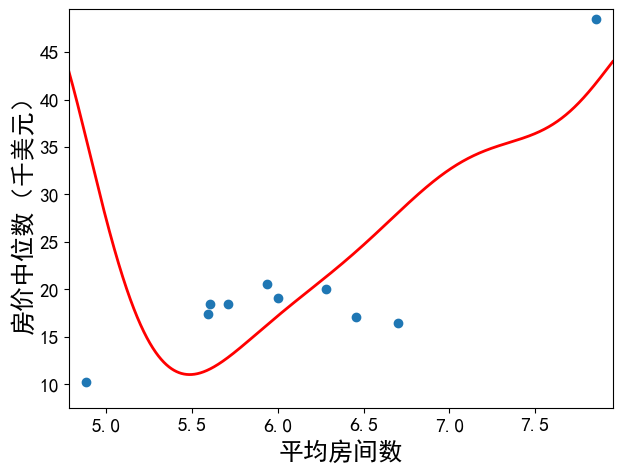

In [38]:
print(f'Parameter b: {b}')
print(f'Parameters w: {w}')

x_min = np.min([np.min(x_train), np.min(x_test)]) - 1
x_max = np.max([np.max(x_train), np.max(x_test)]) + 1

x_linear = np.linspace(x_min, x_max, 10000) # Create a sequence of x to draw prediction function

x_linear_scatter = norm_recover(x_linear, x_a, x_b, norm_type=norm_type)
x_train_scatter = norm_recover(x_train, x_a, x_b, norm_type=norm_type)

# Draw prediction function
fig, ax, _ = draw_uniform_scatter(x_train_scatter, y_train, x_lim, y_lim) # Plot the scatter
# plt.savefig(f'polylinearfit_scatter_p{p}_aug_{num_samples}.png', dpi=300) # Make figure clearer
plt.show()

# Draw prediction function
fig, ax, _ = draw_uniform_scatter(x_train_scatter, y_train, x_lim, y_lim) # Plot the scatter

x_linear_exp = [x_linear ** (i+1) for i in range(p)]
x_linear_exp = np.array(x_linear_exp).T

y_linear = np.matmul(x_linear_exp, w) + b

ax.plot(x_linear_scatter, y_linear, color='red', linewidth=2)

# plt.savefig(f'polylinearfit_p{p}_aug_{num_samples}.png', dpi=300) # Make figure clearer
plt.show()

# Draw prediction function
fig, ax, _ = draw_uniform_scatter(x_test_scatter, y_test, x_lim, y_lim) # Plot the scatter

x_linear_exp = [x_linear ** (i+1) for i in range(p)]
x_linear_exp = np.array(x_linear_exp).T

y_linear = np.matmul(x_linear_exp, w) + b

ax.plot(x_linear_scatter, y_linear, color='red', linewidth=2)

# plt.savefig(f'polylinearfit_test_p{p}_aug_{num_samples}.png', dpi=300) # Make figure clearer
plt.show()

引入更多的特征

In [39]:
# Split data into training and testing domains (Not for this section)
X_tr1, X_te1, Y_tr1, Y_te1 = train_test_split(data, target, test_size=0.2, random_state=42)

np.random.seed(42) # Set the random seed for reproducibility
random_indices = np.random.choice(X_tr1.shape[0], 50, replace=False)
x_tr1 = X_tr1[random_indices, :]
y_tr1 = Y_tr1[random_indices]

random_indices = np.random.choice(X_te1.shape[0], 10, replace=False)
x_te1 = X_te1[random_indices, :]
y_te1 = Y_te1[random_indices]

# Train model
w, b, logs = train_poly_mdl(x_tr1, y_tr1, x_te1, y_te1, lr=100, max_epoch=10000, batch_size=10, disp=True)
err_train = logs['err_train'][-1]
err_test = logs['err_test'][-1]

print(f'p={x_tr1.shape[1]}\t Training avg_err: {err_train}\t Testing avg_err: {err_test}')
print(f'Parameter b: {b}')
print(f'Parameters w: {w}')

Epoch 10000: train loss (12.20408873), test loss (19.54637160), train error (3.5217), test error (5.2277)
p=12	 Training avg_err: 3.5216526079617405	 Testing avg_err: 5.2276939732086385
Parameter b: 4.038116206729232
Parameters w: [ 0.09202154  0.02788523 -0.30660568  7.91958305  3.4476876   3.1177809
  0.06936759 -0.06548247 -0.19003097  0.01275331  0.18956206 -0.94851071]


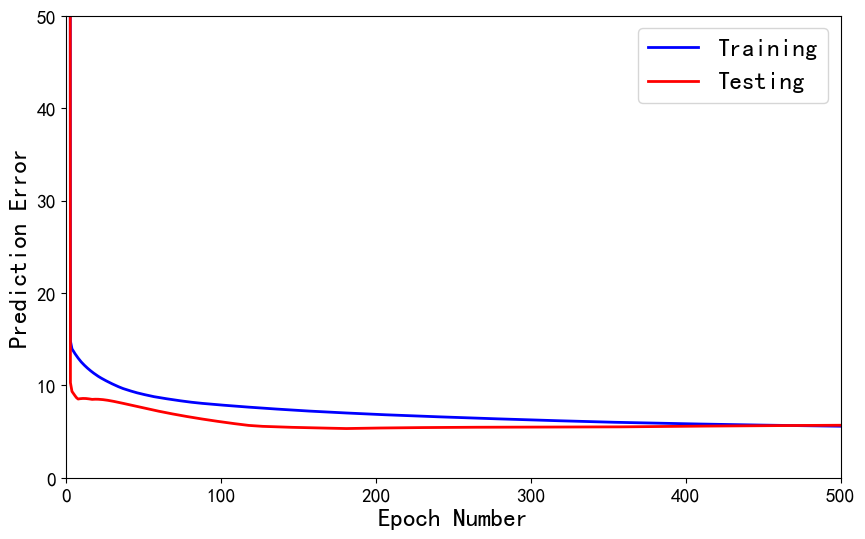

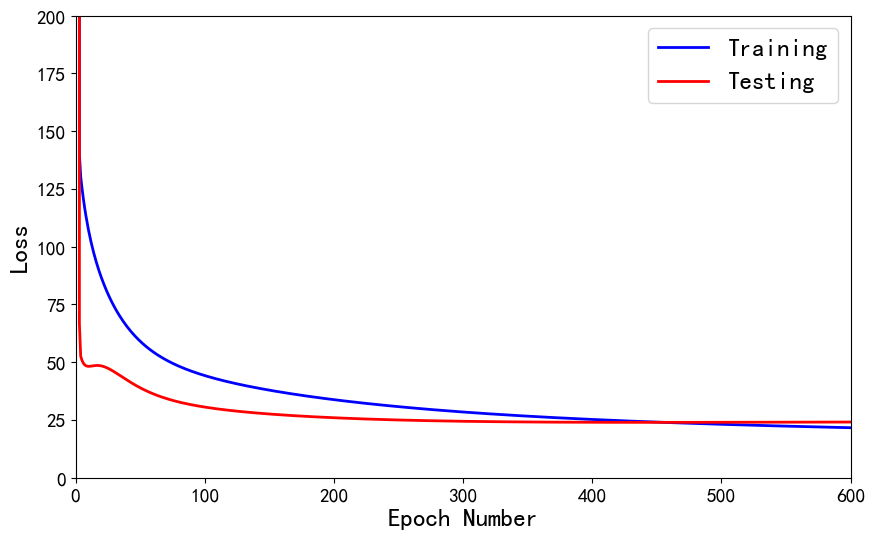

In [40]:
fig, ax = plt.subplots(figsize=(10,6))

plt.plot(logs['err_train'], color='blue', linewidth=2, zorder=1, label='Training') # Plot training losses
plt.plot(logs['err_test'], color='red', linewidth=2, zorder=1, label='Testing') # Plot training losses
plt.legend(ncol=1, fontsize=label_size)

ax.set_xlim(0, 500)
ax.set_ylim(0, 50)

ax.set_xlabel('Epoch Number', fontsize=label_size)
ax.set_ylabel('Prediction Error', fontsize=label_size)
ax.tick_params(axis='both', which='major', labelsize=ticklabel_size)

# plt.savefig('Expand_ftr_error.png', dpi=300) # Make figure clearer
plt.show()

fig, ax = plt.subplots(figsize=(10,6))

plt.plot(logs['loss_train'], color='blue', linewidth=2, zorder=1, label='Training') # Plot training losses
plt.plot(logs['loss_test'], color='red', linewidth=2, zorder=1, label='Testing') # Plot training losses
plt.legend(ncol=1, fontsize=label_size)

ax.set_xlim(0, 600)
ax.set_ylim(0, 200)

ax.set_xlabel('Epoch Number', fontsize=label_size)
ax.set_ylabel('Loss', fontsize=label_size)
ax.tick_params(axis='both', which='major', labelsize=ticklabel_size)

# plt.savefig('Expand_ftr_loss.png', dpi=300) # Make figure clearer
plt.show()

### 2.5.2 正则化

L2 Norm

In [41]:
lambda_list = [0, 1, 10, 100, 1000, 10000, 100000]

b_list = []
w_list = []
err_list = []
loss_list = []

for lbd in lambda_list:
    # Train model
    w, b, logs = train_poly_mdl(x_tr1, y_tr1, x_te1, y_te1, lr=1, max_epoch=100000, batch_size=10, disp=True, regulization_method='L2', regulization_lambda=lbd)
    b_list.append(b)
    w_list.append(w)
    
    err_train = logs['err_train'][-1]
    err_test = logs['err_test'][-1]
    err_list.append([err_train, err_test])
    
    loss_train = logs['loss_train'][-1]
    loss_test = logs['loss_test'][-1]
    loss_list.append([loss_train, loss_test])

    print(f'Lambda={lbd}\t Training avg_err: {err_train}\t Testing avg_err: {err_test}')

Epoch 10000: train loss (12.11842038), test loss (20.35616558), train error (3.5572), test error (5.3124)
Epoch 20000: train loss (11.70905364), test loss (18.83078351), train error (3.4503), test error (5.0973)
Epoch 30000: train loss (11.43995411), test loss (18.55408478), train error (3.4122), test error (5.0036)
Epoch 40000: train loss (11.22180988), test loss (18.46510333), train error (3.3874), test error (4.9401)
Epoch 50000: train loss (11.03903768), test loss (18.40946628), train error (3.3666), test error (4.8863)
Epoch 60000: train loss (10.88261766), test loss (18.35458927), train error (3.3518), test error (4.8372)
Epoch 70000: train loss (10.74621753), test loss (18.29293841), train error (3.3373), test error (4.7916)
Epoch 80000: train loss (10.62531072), test loss (18.22309084), train error (3.3230), test error (4.7487)
Epoch 90000: train loss (10.51663977), test loss (18.14543579), train error (3.3090), test error (4.7083)
Epoch 100000: train loss (10.41784294), test l

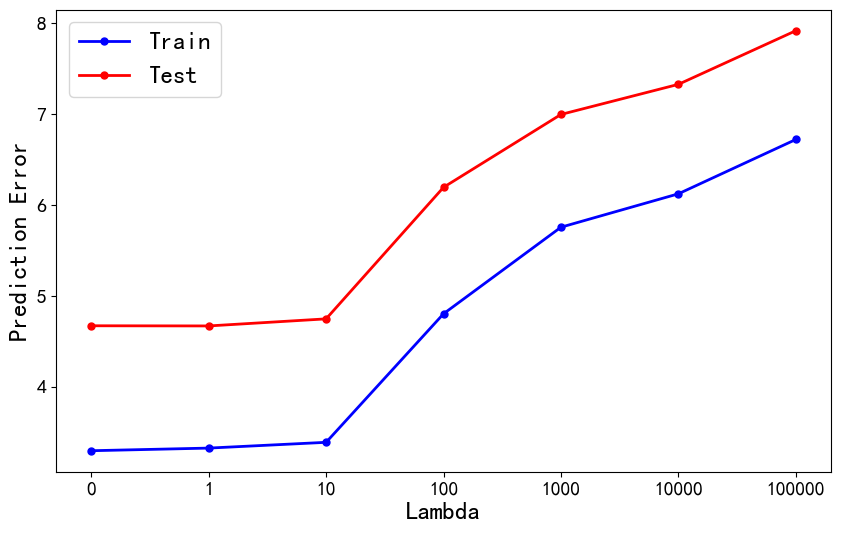

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_39228\2202923345.py:33: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = plt.cm.get_cmap('jet', 12)


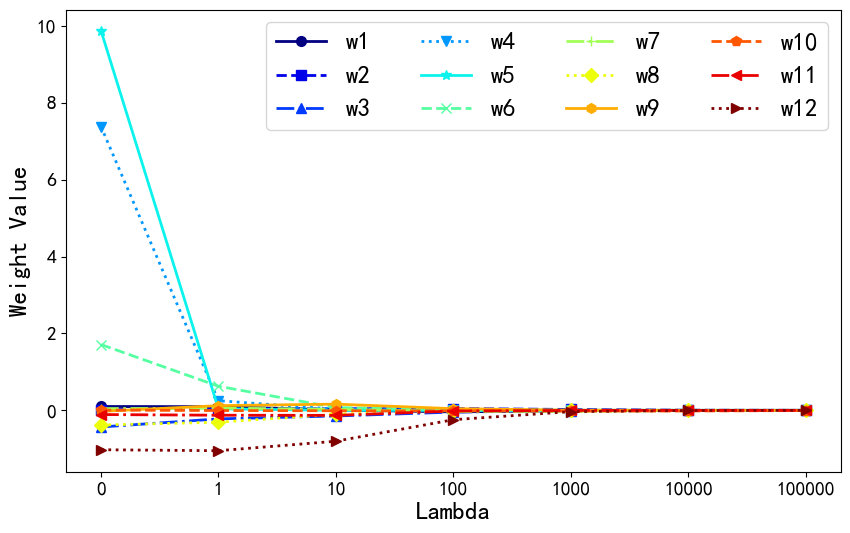

In [42]:
b_array = np.array(b_list)
w_array = np.array(w_list)
err_array = np.array(err_list)
loss_array = np.array(loss_list)

# Draw errors vs lambda
fig, ax = plt.subplots(figsize=(10,6))

xticks = np.arange(len(lambda_list))
xticklabels = lambda_list

plt.plot(xticks, err_array[:, 0], color='blue', marker='.', markersize=10, linewidth=2, zorder=1, label='Train') # Plot training losses
plt.plot(xticks, err_array[:, 1], color='red', marker='.', markersize=10, linewidth=2, zorder=1, label='Test') # Plot training losses
plt.legend(ncol=1, fontsize=label_size)

ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels)
# ax.set_ylim(0, 25)

ax.set_xlabel('Lambda', fontsize=label_size)
ax.set_ylabel('Prediction Error', fontsize=label_size)
ax.tick_params(axis='both', which='major', labelsize=ticklabel_size)

# plt.savefig('lambda_2_vs_error.png', dpi=300) # Make figure clearer
plt.show()

# Draw weights changes
fig, ax = plt.subplots(figsize=(10,6))

xticks = np.arange(len(lambda_list))
xticklabels = lambda_list

colormap = plt.cm.get_cmap('jet', 12)
linestyles = ['-', '--', '-.', ':', '-', '--', '-.', ':', '-', '--', '-.', ':']
markers = ['o', 's', '^', 'v', '*', 'x', '+', 'D', 'h', 'p', '<', '>']
for i in range(w_array.shape[1]):
    plt.plot(xticks, w_array[:, i], color=colormap(i), linestyle=linestyles[i], marker=markers[i], markersize=7, linewidth=2, zorder=1, label=f'w{i+1}') # Plot training losses
plt.legend(ncol=4, fontsize=label_size, loc='upper right')

ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels)
# ax.set_ylim(0, 25)

ax.set_xlabel('Lambda', fontsize=label_size)
ax.set_ylabel('Weight Value', fontsize=label_size)
ax.tick_params(axis='both', which='major', labelsize=ticklabel_size)

# plt.savefig('lambda_2_vs_weights.png', dpi=300) # Make figure clearer
plt.show()

L1 Norm

In [43]:
lambda_list = [0, 1, 10, 100, 1000, 10000, 100000]

b_list = []
w_list = []
err_list = []
loss_list = []

for lbd in lambda_list:
    # Train model
    w, b, logs = train_poly_mdl(x_tr1, y_tr1, x_te1, y_te1, lr=1, max_epoch=100000, batch_size=10, disp=True, regulization_method='L1', regulization_lambda=lbd)
    b_list.append(b)
    w_list.append(w)
    
    err_train = logs['err_train'][-1]
    err_test = logs['err_test'][-1]
    err_list.append([err_train, err_test])
    
    loss_train = logs['loss_train'][-1]
    loss_test = logs['loss_test'][-1]
    loss_list.append([loss_train, loss_test])

    print(f'Lambda={lbd}\t Training avg_err: {err_train}\t Testing avg_err: {err_test}')

Epoch 10000: train loss (12.39129709), test loss (20.90164863), train error (3.6067), test error (5.3849)
Epoch 20000: train loss (12.02603866), test loss (19.32756814), train error (3.5108), test error (5.2152)
Epoch 30000: train loss (11.80345352), test loss (18.80454303), train error (3.4566), test error (5.1147)
Epoch 40000: train loss (11.62184208), test loss (18.60226145), train error (3.4312), test error (5.0523)
Epoch 50000: train loss (11.46409798), test loss (18.51047730), train error (3.4129), test error (5.0062)
Epoch 60000: train loss (11.32459119), test loss (18.46001154), train error (3.3979), test error (4.9676)
Epoch 70000: train loss (11.20001628), test loss (18.42482035), train error (3.3845), test error (4.9329)
Epoch 80000: train loss (11.08787970), test loss (18.39437212), train error (3.3721), test error (4.9006)
Epoch 90000: train loss (10.98617979), test loss (18.36419440), train error (3.3610), test error (4.8700)
Epoch 100000: train loss (10.89328790), test l

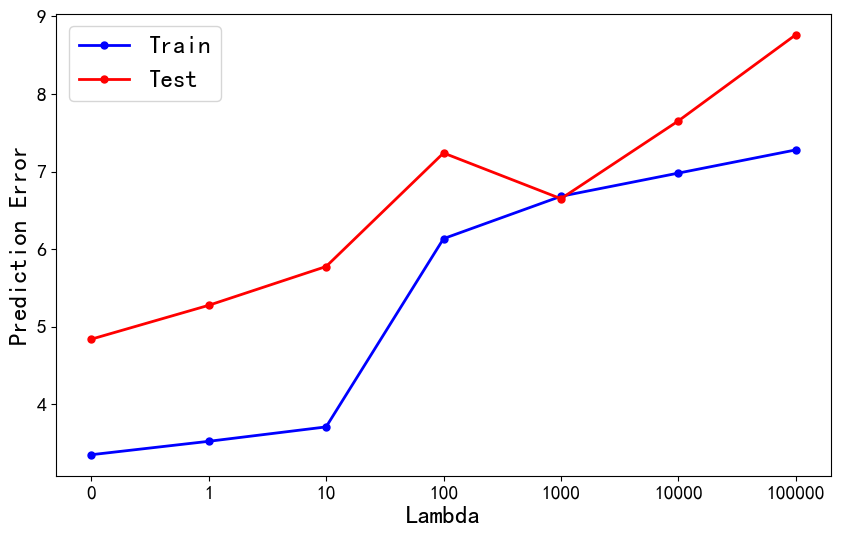

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_39228\4138392992.py:33: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = plt.cm.get_cmap('jet', 12)


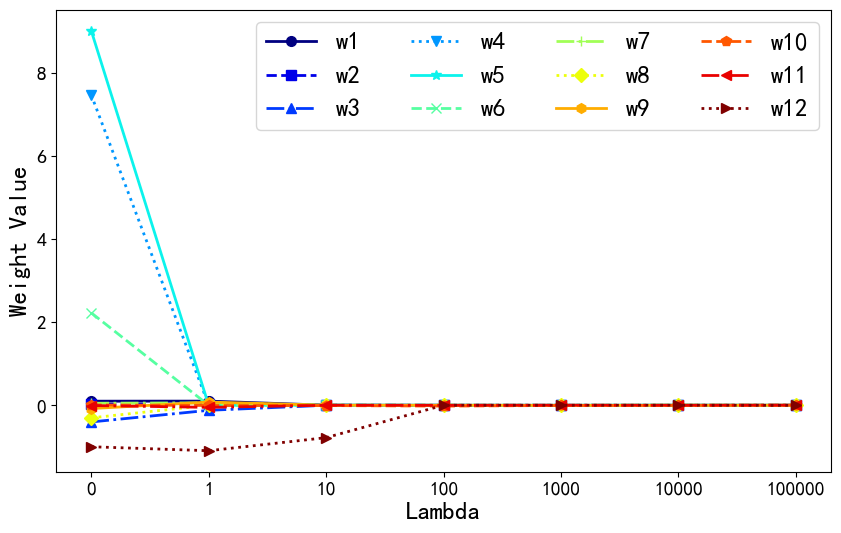

In [44]:
b_array = np.array(b_list)
w_array = np.array(w_list)
err_array = np.array(err_list)
loss_array = np.array(loss_list)

# Draw errors vs lambda
fig, ax = plt.subplots(figsize=(10,6))

xticks = np.arange(len(lambda_list))
xticklabels = lambda_list

plt.plot(xticks, err_array[:, 0], color='blue', marker='.', markersize=10, linewidth=2, zorder=1, label='Train') # Plot training losses
plt.plot(xticks, err_array[:, 1], color='red', marker='.', markersize=10, linewidth=2, zorder=1, label='Test') # Plot training losses
plt.legend(ncol=1, fontsize=label_size)

ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels)
# ax.set_ylim(0, 25)

ax.set_xlabel('Lambda', fontsize=label_size)
ax.set_ylabel('Prediction Error', fontsize=label_size)
ax.tick_params(axis='both', which='major', labelsize=ticklabel_size)

# plt.savefig('lambda_1_vs_error.png', dpi=300) # Make figure clearer
plt.show()

# Draw weights changes
fig, ax = plt.subplots(figsize=(10,6))

xticks = np.arange(len(lambda_list))
xticklabels = lambda_list

colormap = plt.cm.get_cmap('jet', 12)
linestyles = ['-', '--', '-.', ':', '-', '--', '-.', ':', '-', '--', '-.', ':']
markers = ['o', 's', '^', 'v', '*', 'x', '+', 'D', 'h', 'p', '<', '>']
for i in range(w_array.shape[1]):
    plt.plot(xticks, w_array[:, i], color=colormap(i), linestyle=linestyles[i], marker=markers[i], markersize=7, linewidth=2, zorder=1, label=f'w{i+1}') # Plot training losses
plt.legend(ncol=4, fontsize=label_size, loc='upper right')

ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels)
# ax.set_ylim(0, 25)

ax.set_xlabel('Lambda', fontsize=label_size)
ax.set_ylabel('Weight Value', fontsize=label_size)
ax.tick_params(axis='both', which='major', labelsize=ticklabel_size)

# plt.savefig('lambda_1_vs_weights.png', dpi=300) # Make figure clearer
plt.show()

### 2.5.3 交叉验证

仅提供三种方法的思路

In [45]:
# Set cross validation methods
cv_methods = ['leave-p-out', 'k-fold', 'boostrapping']

# Split data into train and test sets
X_tr2, x_te2, Y_tr2, y_te2 = train_test_split(data, target, test_size=0.2)
print(f'Training dataset size: {X_tr2.shape[0]}, testing dataset size: {x_te2.shape[0]}')

# Leave-p-out: Split X_tr2 and Y_tr2 into train and cross-validation sets with train-val ratio
tr_val_ratio = 0.1
x_tr2, x_val2, y_tr2, y_val2 = train_test_split(X_tr2, Y_tr2, test_size=tr_val_ratio)
print(f'Training dataset size: {x_tr2.shape[0]}, cross-validation dataset size: {x_val2.shape[0]}')

# Leave-p-out: Select p random samples as cross-validation data
random_indices = np.random.permutation(X_tr2.shape[0])
val_num = 10 # Set the number of test data
train_idx = random_indices[val_num:]
val_idx = random_indices[:val_num]
x_tr2 = X_tr2[train_idx, :]
y_tr2 = Y_tr2[train_idx]
x_te2 = X_tr2[val_idx, :]
y_te2 = Y_tr2[val_idx]
print(f'Training dataset size: {x_tr2.shape[0]}, cross-validation dataset size: {x_te2.shape[0]}')

# K-fold: Divide training dataset into K folds and leave one fold for CV in each time
from sklearn.model_selection import KFold
k = 5
kf = KFold(n_splits=k)

# Display kfold number and datasets size
for ifold, (train_index, val_index) in enumerate(kf.split(X_tr2)):
    x_tr2, x_te2 = X_tr2[train_index], X_tr2[val_index]
    y_tr2, y_te2 = Y_tr2[train_index], Y_tr2[val_index]
    print(f'Train-CV samples in fold {ifold+1}: {x_tr2.shape[0]}-{x_te2.shape[0]}')

# K-fold: Manual
k = 5
fold_size = X_tr2.shape[0] // k # Calculate the size of each fold
fold_indices = np.array_split(random_indices, k) # Split the indices into k folds
for ifold in range(k):
    val_idx = fold_indices[ifold]
    train_idx = np.concatenate([fold_indices[i] for i in range(k) if i != ifold])

    x_tr2 = X_tr2[train_idx, :]
    y_tr2 = Y_tr2[train_idx]
    x_te2 = X_tr2[val_idx, :]
    y_te2 = Y_tr2[val_idx]

    print(f'Train-CV samples in fold {ifold+1}: {x_tr2.shape[0]}-{x_te2.shape[0]}')

# Boostrapping
bt_set_num = 10

# Generate 10 random number bigger than 10
train_size_list = [np.random.randint(200, 500) for _ in range(bt_set_num)]
print(f'Boostrapping training data sets: {train_size_list}')
val_size_list = [np.random.randint(50, 100) for _ in range(bt_set_num)]
print(f'Boostrapping cross-validation data sets: {val_size_list}')

train_sample_dict = {}
val_sample_dict = {}
for ibt in range(bt_set_num):
    
    # Get indices of training and testing data
    train_sample_dict[ibt] = np.random.choice(X_tr2.shape[0], train_size_list[ibt], replace=True)
    val_sample_dict[ibt] = np.random.choice(X_tr2.shape[0], val_size_list[ibt], replace=True)

for ibt in range(bt_set_num):
    print(f'Training dataset size: {train_sample_dict[ibt].shape[0]}, cross-validation dataset size: {val_sample_dict[ibt].shape[0]}')  


Training dataset size: 404, testing dataset size: 102
Training dataset size: 363, cross-validation dataset size: 41
Training dataset size: 394, cross-validation dataset size: 10
Train-CV samples in fold 1: 323-81
Train-CV samples in fold 2: 323-81
Train-CV samples in fold 3: 323-81
Train-CV samples in fold 4: 323-81
Train-CV samples in fold 5: 324-80
Train-CV samples in fold 1: 323-81
Train-CV samples in fold 2: 323-81
Train-CV samples in fold 3: 323-81
Train-CV samples in fold 4: 323-81
Train-CV samples in fold 5: 324-80
Boostrapping training data sets: [476, 220, 223, 403, 369, 372, 279, 440, 457, 389]
Boostrapping cross-validation data sets: [96, 82, 66, 70, 73, 85, 54, 93, 52, 80]
Training dataset size: 476, cross-validation dataset size: 96
Training dataset size: 220, cross-validation dataset size: 82
Training dataset size: 223, cross-validation dataset size: 66
Training dataset size: 403, cross-validation dataset size: 70
Training dataset size: 369, cross-validation dataset size:

## 2.6 实验：基于线性回归的房价预测

此部分需要同学自行完成各个任务要求，训练并评估房价预测模型：
* 数据读取及预处理
* 模型设计：线性模型、非线性模型
* 模型训练：蛮力法、梯度下降、学习率
* 过拟合相关内容；数据增强、正则化、交叉验证